In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import rcParams
from matplotlib.markers import MarkerStyle
from scipy.optimize import curve_fit
from scipy.signal import find_peaks
import os
import re

In [2]:
PX_PER_MM = 7.532343134764206
FRAME_PER_SECOND = 60

plt.style.use("default")
COLOR = 'black'

# FIGURE & AXES
rcParams['figure.figsize'] = (15,10)
rcParams['figure.dpi'] = 70
rcParams['axes.grid'] = True
rcParams['axes.xmargin'] = 0
rcParams['axes.labelcolor'] = COLOR
rcParams['axes.facecolor'] = '#ebebeb'
rcParams['axes.grid.axis'] = 'both'
rcParams['axes.axisbelow'] = True
rcParams['text.color'] = COLOR
rcParams['text.color'] = COLOR
rcParams['xtick.color'] = COLOR
rcParams['ytick.color'] = COLOR
rcParams['grid.color'] = COLOR


# FONT
rcParams["font.family"] = "serif"
rcParams["mathtext.fontset"] = "cm"
rcParams['axes.titlesize'] = 36
rcParams['axes.labelsize'] = 36
rcParams['ytick.labelsize'] = 22
rcParams['xtick.labelsize'] = 22
rcParams['legend.fontsize'] = 28
rcParams['legend.title_fontsize'] = 28

rcParams['text.latex.preamble'] = "\n".join([
    r'\usepackage[version=3]{mhchem}'
])

# SAVE
# rcParams['savefig.format'] = 'pdf'
rcParams['savefig.bbox'] = 'tight'
# rcParams['savefig.pad_inches'] = 0.05

f_lineal = lambda x,a,b: a*x + b

FREQ_ARRAY = ['2Hz','3Hz','4Hz','5Hz','6Hz','7Hz','7.33Hz','7.66Hz','8Hz','9Hz','10Hz']
# FREQ_ARRAY = ['2Hz','3Hz','4Hz','5Hz','6Hz','7Hz','8Hz','9Hz','10Hz']
VOLT_ARRAY = ['0,5Vpp', '1,00Vpp', '1,50Vpp', '2,00Vpp', '2,50Vpp']

FREQ_ARRAY_VALUES = [2,3,4,5,6,7,7.33,7.66,8,9,10]
# FREQ_ARRAY_VALUES = [2,3,4,5,6,7,8,9,10]
VOLT_ARRAY_VALUES = [0.5,1,1.5,2,2.5]

#Creating the colormap
norm_v = plt.Normalize(VOLT_ARRAY_VALUES[0],VOLT_ARRAY_VALUES[-1])
cmap_v = plt.colormaps.get_cmap('viridis')
colorscale_v = plt.cm.ScalarMappable(norm_v, cmap_v)

norm_f = plt.Normalize(FREQ_ARRAY_VALUES[0],FREQ_ARRAY_VALUES[-1])
cmap_f = plt.colormaps.get_cmap('plasma')
colorscale_f = plt.cm.ScalarMappable(norm_f, cmap_f)

freq_marker = MarkerStyle("o", fillstyle="left")
volt_marker = MarkerStyle("o", fillstyle="right")

df_slope = pd.DataFrame(index=VOLT_ARRAY_VALUES, columns=FREQ_ARRAY_VALUES,dtype=object)
df_tail_amplitude = pd.DataFrame(index=VOLT_ARRAY_VALUES, columns=FREQ_ARRAY_VALUES,dtype=object)
df_head_amplitude = pd.DataFrame(index=VOLT_ARRAY_VALUES, columns=FREQ_ARRAY_VALUES,dtype=object)
df_freq = pd.DataFrame(index=VOLT_ARRAY_VALUES, columns=FREQ_ARRAY_VALUES, dtype=object)

## x(t)

In [3]:
df_x_t = pd.read_csv('datos\\ECO20-45mm\\cabeza\\1,00Vpp-3Hz.csv')
v = '1,00Vpp' 
vval = 1.0
f = '3Hz'
t,x,y = np.array(df_x_t['t']/FRAME_PER_SECOND), np.array(df_x_t['x']/PX_PER_MM), df_x_t['y']/PX_PER_MM
x = -x + np.max(x)
# x_recentered = x - (x[0]-avg_start)

Text(0, 0.5, '$x$ $[\\text{mm}]$')

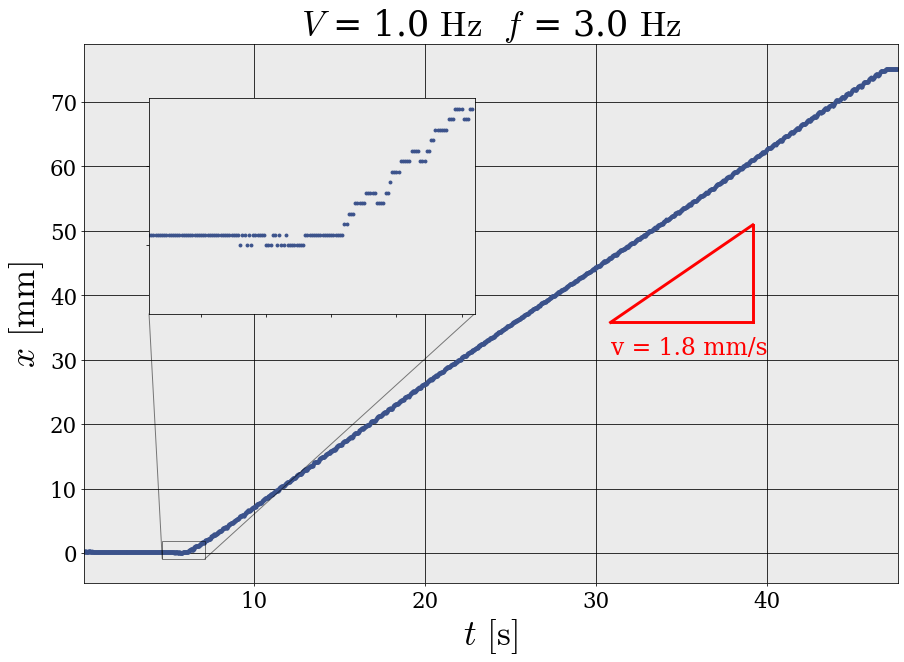

In [7]:
norm = plt.Normalize(0.5,2.5)
cmap = plt.colormaps.get_cmap('viridis')
colorscale = plt.cm.ScalarMappable(norm, cmap)



fig, ax = plt.subplots()
ax.plot(t, x, '.', color = cmap(norm(vval)))

# SLOPE

t_mid = np.array([t[1850], t[2350]])
x_mid = np.array([x[1850]-10, x[2350]-10])

# Calculate slope
slope = np.diff(x_mid) / np.diff(t_mid)

ax.plot(t_mid, x_mid, color='r', lw=3)
ax.plot([t_mid[0], t_mid[1]], [x_mid[0], x_mid[0]], color='r', lw=3)
ax.plot([t_mid[1], t_mid[1]], [x_mid[0], x_mid[1]], color='r', lw=3)

ax.text(t_mid[0], x_mid[0]-5, f'v = {round(slope[0], 1)} mm/s', fontsize=24, color='r')


# INSET AXES
# x1, x2, y1, y2 = t[275], t[425], x[275]-1, x[425]  # subregion of the original image

# axins = ax.inset_axes(
#     [0.08, 0.5, 0.40, 0.4],
#     xlim=(x1, x2), ylim=(y1, y2), xticklabels=[], yticklabels=[])

# axins.plot(t[275:425], x[275:425], '.', color = cmap(norm(vval)))
# axins.grid(None)
# ax.indicate_inset_zoom(axins, edgecolor="black")

ax.set_title(f'$V$ = 1.0 $\\text{{Hz}}$  $f$ = 3.0 $\\text{{Hz}}$')
ax.set_xlabel(f'$t$ $[\\text{{s}}]$')
ax.set_ylabel(f'$x$ $[\\text{{mm}}]$')

# fig.savefig(f'gráficos\\x(t)_1Vpp_3Hz.png')

## Velocidad terminal en función de f y V

### Pendientes para la cabeza

In [3]:
#We prepare a dataframe of all our filenames and a dataframe of all our csv's
csv_names = [filepath for filepath in os.listdir('ECO20-45mm/slopes-xt/cabeza') if '.csv' in filepath]
csv_names = sorted(csv_names,key=lambda v: [int(i) for i in (v.split('-')[1].replace('Hz.csv','').split('.'))])
filenamelist = pd.DataFrame().assign(name = csv_names)
df = [pd.read_csv(f'ECO20-45mm/slopes-xt/cabeza/{f}') for f in filenamelist['name']]

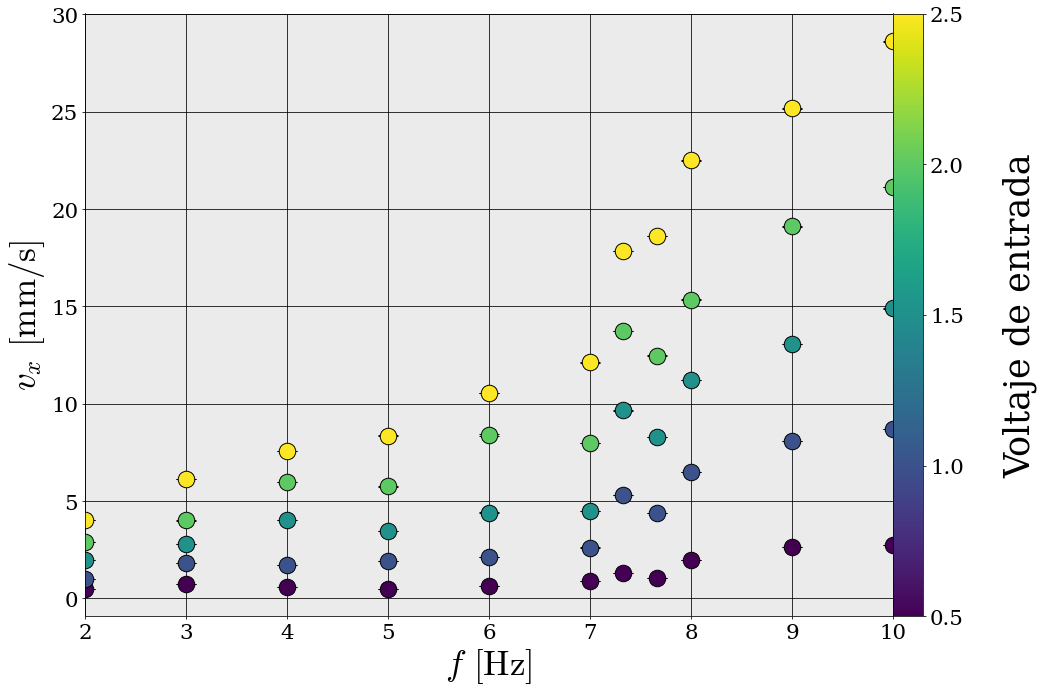

In [4]:
fig, ax = plt.subplots()

for currHz in FREQ_ARRAY:
    
    filtered_namelist = [name for name in csv_names if re.match(r'\b'+currHz+r'\b',name.split('-')[1])] #We get the names of those files

    for filename in filtered_namelist:
        df_txy = df[csv_names.index(filename)] #We retrieve the dataframe corresponding to our current filename
        
        #We retrieve the metadata of our measurements from the filename
        s = filename.split('-')
        v,f = s[0],s[1][:-4]
        vval = (float(v.split('V')[0].replace(',','.')) if 'mV' not in v else float(v.split('mV')[0].replace(',','.'))*1e-3)
        fval = float(f.split('Hz')[0])
        
        #Setting colors for our datapoints
        freq_color = cmap_f(norm_f(fval))
        volt_color = cmap_v(norm_v(vval))
        
        #We retrieve the data from our dataframe
        t,x = df_txy['t'], df_txy['x']
        
        popt, popv = curve_fit(f_lineal, t, x)
        
        err_popt = np.sqrt(np.diag(popv))
        # print(f' {v}-{f} => parametros: {popt[0]}, {popt[1]} ; errores: {err_popt[0]}, {err_popt[1]} ')
        
        df_slope.loc[vval,fval] = (popt[0],err_popt[0])
        
        # Plotting
        ax.errorbar(fval, np.abs(popt[0]), markerfacecolor = volt_color, fmt='o',
                    yerr = err_popt[0], xerr = None, color = 'k', ecolor = 'k',
                    ms=17, elinewidth=2, lw=3, capsize=10)

        
# Colorbar configuration

cbar_term = fig.colorbar(colorscale_v, ax=ax, location='right', orientation='vertical', pad=0, fraction=0.05)
cbar_term.ax.set_ylim(VOLT_ARRAY_VALUES[0],VOLT_ARRAY_VALUES[-1])
cbar_term.ax.set_yticks(VOLT_ARRAY_VALUES)
cbar_term.ax.ticklabel_format(axis='x',style='sci',scilimits=(0,2))
cbar_term.ax.set_ylabel('Voltaje de entrada',labelpad=40)

#Axes configuration
ax.set_xlabel(f'$f$ $[\\text{{Hz}}]$')
ax.set_ylabel(f'$v_x$ $[\\text{{mm/s}}]$')

fig.tight_layout()

Text(0, 0.5, 'Voltaje de entrada')

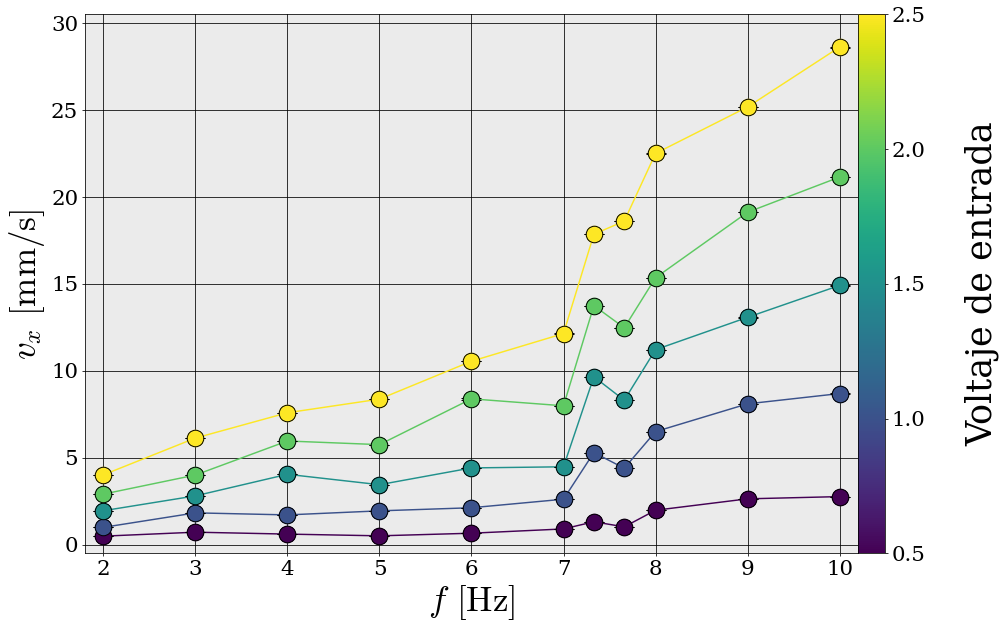

In [76]:
fig,ax = plt.subplots()
for row in df_slope.iterrows():
    volt_color = cmap_v(norm_v(row[0]))
    values = [row[1].iloc[i][0] for i in np.arange(len(row[1]))]
    errors = [row[1].iloc[i][1] for i in np.arange(len(row[1]))]
    ax.plot(FREQ_ARRAY_VALUES,np.abs(values), 'o-', ms=17, color=volt_color)
    ax.errorbar(FREQ_ARRAY_VALUES, np.abs(values), markerfacecolor = volt_color, fmt='o',
            yerr = errors, xerr = None, color = 'k', ecolor = 'k',
            ms=17, elinewidth=2, lw=3, capsize=10)

ax.set_xlabel(f'$f$ $[\\text{{Hz}}]$')
ax.set_ylabel(f'$v_x$ $[\\text{{mm/s}}]$')
ax.set_xlim([1.8,10.2])
ax.set_ylim([-.5,30.5])
#Colorbar configuration
cbar_term = fig.colorbar(colorscale_v, ax=ax, location='right', orientation='vertical', pad=0, fraction=0.05)
cbar_term.ax.set_ylim(VOLT_ARRAY_VALUES[0],VOLT_ARRAY_VALUES[-1])
cbar_term.ax.ticklabel_format(axis='x',style='sci',scilimits=(0,2))
cbar_term.ax.set_yticks(VOLT_ARRAY_VALUES)
cbar_term.ax.set_ylabel('Voltaje de entrada',labelpad=40)

In [6]:
import natsort
npz_names = natsort.natsorted([filepath for filepath in os.listdir('ECO20-45mm/forma_cola_rotada') if '.npz' in filepath])

/tmp/ipykernel_1447879/3115978092.py:84: RuntimeWarning: Mean of empty slice.
  ax_head.errorbar(fval, head_amplitude.mean(), markerfacecolor = volt_color, fmt='o',
/home/arcus/Facultad/Laboratorio 6/Nado-ondulatorio/.venv/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/arcus/Facultad/Laboratorio 6/Nado-ondulatorio/.venv/lib/python3.10/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/arcus/Facultad/Laboratorio 6/Nado-ondulatorio/.venv/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/arcus/Facultad/Laboratorio 6/Nado-ondulatorio/.venv/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  re

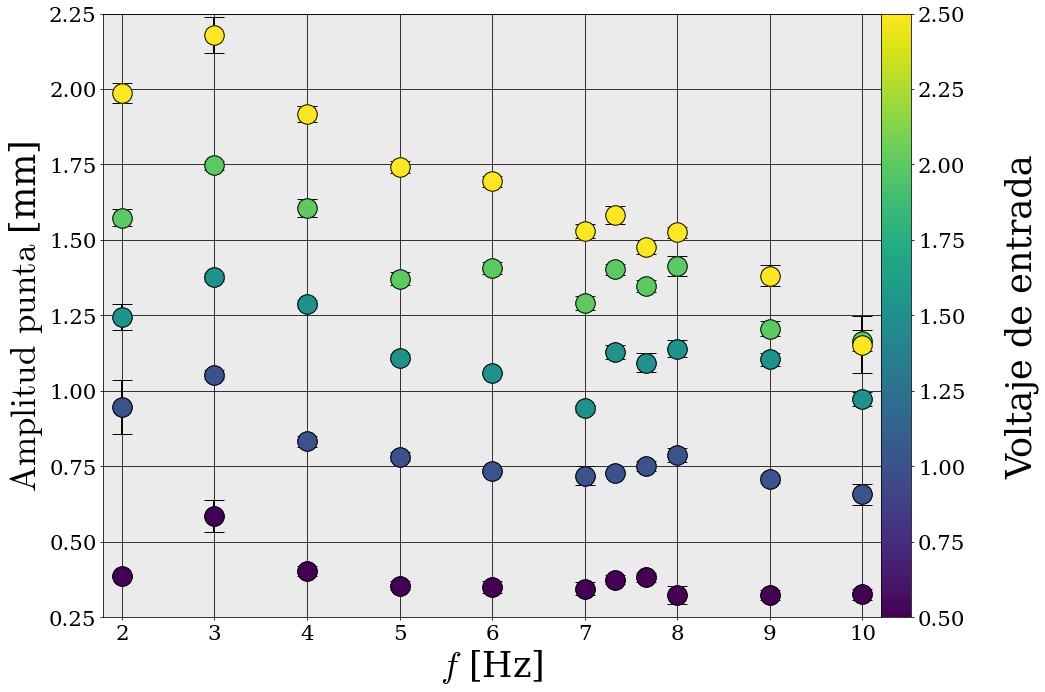

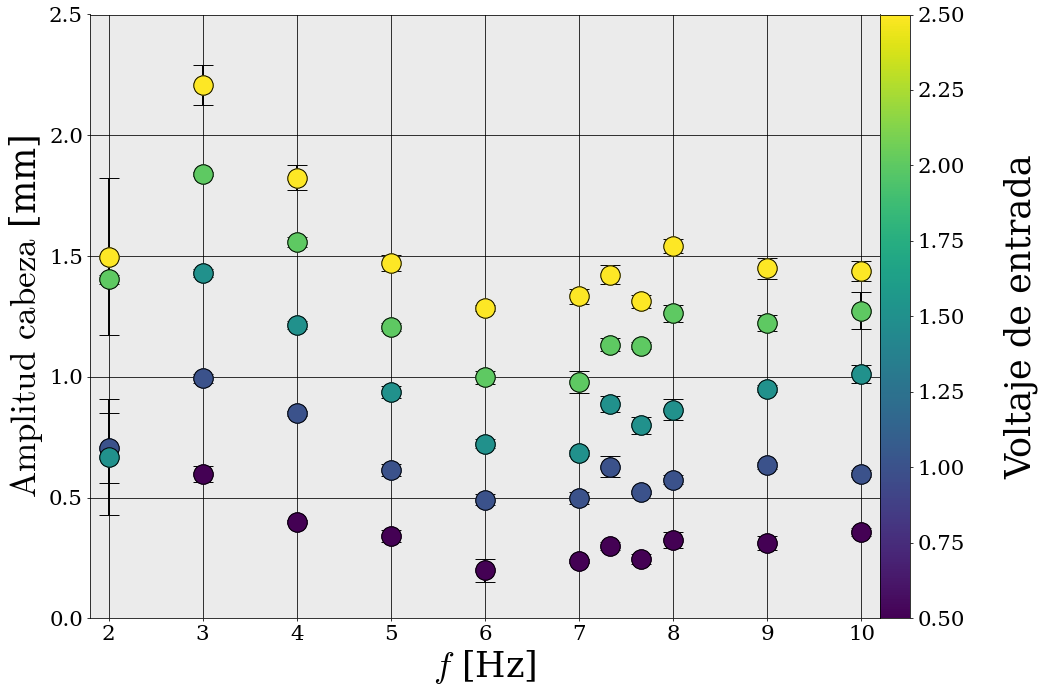

In [7]:
index_start = 0

fig, ax = plt.subplots()
fig_head, ax_head = plt.subplots()

for currHz in FREQ_ARRAY:
    filtered_namelist = [name for name in npz_names if re.match(r'\b'+currHz+r'\b',name.split('-')[1])] #We get the names of those files
    rotated_tails = np.array([np.load(f'ECO20-45mm/forma_cola_rotada/{name}', allow_pickle=True)['arr'] for name in filtered_namelist], dtype=object)
    
    for rotated_tail,filename in zip(rotated_tails,filtered_namelist):
        tail_extremes = np.array([(tail[1][0], tail[1][-1]) for tail in rotated_tail])
        head_position = tail_extremes[:,0]/PX_PER_MM
        tail_position = tail_extremes[:,1]/PX_PER_MM
        
        # fig1,ax1 = plt.subplots()
        
        N_PERIOD = 5*int((fval**-1)*FRAME_PER_SECOND)
        tail_amplitude = np.array([])
        head_amplitude = np.array([])

        for wave_start in np.arange(len(tail_extremes))[::N_PERIOD]:
            if tail_position.size - wave_start > N_PERIOD:
                tail_in_wave = tail_position[wave_start: wave_start + N_PERIOD + 1]
                x_line = np.arange(0, len(tail_in_wave))
                popt,popv = curve_fit(f_lineal, x_line, tail_in_wave)
                line = f_lineal(x_line,*popt)

                
                max_peaks, _ = find_peaks(tail_in_wave, width = 2, height=line)
                min_peaks, _ = find_peaks(-tail_in_wave, width = 2, height=-line)
                lim = min(max_peaks.size,min_peaks.size)
                max_peaks = max_peaks[:lim]
                min_peaks = min_peaks[:lim]

                tail_amplitude_in_wave = np.array([])
                for (mP,MP) in zip (tail_in_wave[min_peaks],tail_in_wave[max_peaks]):
                    tail_amplitude_in_wave = np.append(tail_amplitude_in_wave, (MP - mP)/(2))
                    
            if head_position.size - wave_start > N_PERIOD:    
                head_in_wave = head_position[wave_start: wave_start + N_PERIOD + 1]
                x_line = np.arange(0, len(head_in_wave))
                popt,popv = curve_fit(f_lineal, x_line, head_in_wave)
                line = f_lineal(x_line,*popt)

                
                max_peaks, _ = find_peaks(head_in_wave, width = 2, height=line)
                min_peaks, _ = find_peaks(-head_in_wave, width = 2, height=-line)
                lim = min(max_peaks.size,min_peaks.size)
                max_peaks = max_peaks[:lim]
                min_peaks = min_peaks[:lim]

                head_amplitude_in_wave = np.array([])
                for (mP,MP) in zip (head_in_wave[min_peaks],head_in_wave[max_peaks]):
                    head_amplitude_in_wave = np.append(head_amplitude_in_wave, (MP - mP)/(2))


                # Gráficos de criterio COLA
                # ax1.plot(x_line + wave_start, line, color='g')
                # ax1.plot(max_peaks + wave_start,tail_in_wave[max_peaks], 'x', color='r')
                # ax1.plot(min_peaks + wave_start,tail_in_wave[min_peaks], 'x', color='b')
                # Gráficos de criterio CABEZA
                # ax1.plot(x_line + wave_start, line, color='g')
                # ax1.plot(max_peaks + wave_start,head_in_wave[max_peaks], 'x', color='r')
                # ax1.plot(min_peaks + wave_start,head_in_wave[min_peaks], 'x', color='b')

        
        tail_amplitude = np.append(tail_amplitude, tail_amplitude_in_wave)
        head_amplitude = np.append(head_amplitude, head_amplitude_in_wave)
        
        #We retrieve the metadata of our measurements from the filename
        s = filename.split('.')[0].split('-')
        v,f = s[0],s[1]
        vval = (float(v.split('V')[0].replace(',','.')) if 'mV' not in v else float(v.split('mV')[0].replace(',','.'))*1e-3)
        fval = float(f.split('Hz')[0].replace(',','.'))

        #Setting colors for our datapoints
        freq_color = cmap_f(norm_f(fval))
        volt_color = cmap_v(norm_v(vval))
                
        ax.errorbar(fval, tail_amplitude.mean(), markerfacecolor = volt_color, fmt='o',
                    yerr = tail_amplitude.std(), xerr = None, color = 'k', ecolor = 'k',
                    ms=20, elinewidth=2, lw=3, capsize=10)
        
        ax_head.errorbar(fval, head_amplitude.mean(), markerfacecolor = volt_color, fmt='o',
            yerr = head_amplitude.std(), xerr = None, color = 'k', ecolor = 'k',
            ms=20, elinewidth=2, lw=3, capsize=10)

        df_tail_amplitude.loc[vval,fval] = (tail_amplitude.mean(), tail_amplitude.std())
        df_head_amplitude.loc[vval,fval] = (head_amplitude.mean(), head_amplitude.std())

        ax.plot(fval, tail_amplitude.mean(), 'o', color= volt_color, ms=20)
        #Axes configuration
        ax.set_xlabel('$f$ [Hz]')
        ax.set_ylabel('$\\text{Amplitud punta}$ [mm]')
        
        ax_head.plot(fval, head_amplitude.mean(), 'o', color= volt_color, ms=20)
        #Axes configuration
        ax_head.set_xlabel('$f$ [Hz]')
        ax_head.set_ylabel('$\\text{Amplitud cabeza}$ [mm]')    


ax.set_ylim([0.25,2.25])
ax.set_xlim([1.8,10.2])
#Colorbar configuration
cbar_term = fig.colorbar(colorscale_v, ax=ax, location='right', orientation='vertical', pad=0, fraction=0.05)
cbar_term.ax.set_ylim(0.5,2.5)
cbar_term.ax.ticklabel_format(axis='x',style='sci',scilimits=(0,2))
cbar_term.ax.set_ylabel('Voltaje de entrada',labelpad=40)
fig.tight_layout()

ax_head.set_ylim([0,2.5])
ax_head.set_xlim([1.8,10.2])
#Colorbar configuration
cbar_term = fig.colorbar(colorscale_v, ax=ax_head, location='right', orientation='vertical', pad=0, fraction=0.05)
cbar_term.ax.set_ylim(0.5,2.5)
cbar_term.ax.ticklabel_format(axis='x',style='sci',scilimits=(0,2))
cbar_term.ax.set_ylabel('Voltaje de entrada',labelpad=40)
fig_head.tight_layout()

Text(0, 0.5, 'Voltaje de entrada')

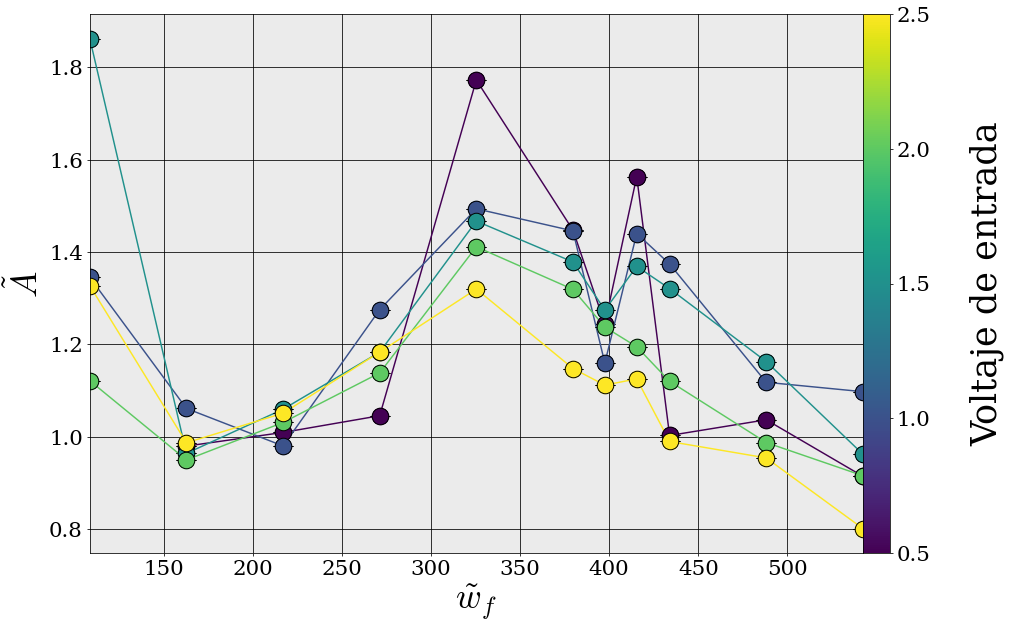

In [8]:
fig,ax = plt.subplots()

a = 502*1e-6 #[µm] -> [m]
E = 42 #[kPa]
I = np.pi*a**4/4 #[momento de inercia]
S = np.pi*a**2 #[m²]
rho = 1e3#[kg/m³]
B = E*I #[bending]
L = 45e-3 # [mm] -> [m]
µ = (0.032*1e-3)/L #[kg/m]
w0 = (((2*np.pi)/((L)**2)))*np.sqrt(B/(µ + rho*S))
ADIM_FREQ = 2*np.pi*np.array(FREQ_ARRAY_VALUES)/w0
for row_tail,row_head in zip(df_tail_amplitude.iterrows(),df_head_amplitude.iterrows()):
    volt_color = cmap_v(norm_v(row_tail[0]))
    tail = np.array([row_tail[1].iloc[i][0] for i in np.arange(len(row_tail[1]))])
    err_tail = np.array([row_tail[1].iloc[i][1] for i in np.arange(len(row_tail[1]))])
    head = np.array([row_head[1].iloc[i][0] for i in np.arange(len(row_head[1]))])
    err_head = np.array([row_head[1].iloc[i][1] for i in np.arange(len(row_head[1]))])

    ax.plot(ADIM_FREQ,np.abs(tail/head), 'o-', ms=17, color=volt_color)
    ax.errorbar(ADIM_FREQ, np.abs(tail/head), markerfacecolor = volt_color, fmt='o',
            yerr = 0, xerr = None, color = 'k', ecolor = 'k',#TODO: Propagar error de adimensionalizar
            ms=17, elinewidth=2, lw=3, capsize=10)

ax.set_xlabel('$\\tilde{w}_f$')
ax.set_ylabel('$\\tilde{A}$')    
# ax.set_ylim([0,2.3])
# ax.set_xlim([1.8,10.2])
#Colorbar configuration
cbar_term = fig.colorbar(colorscale_v, ax=ax, location='right', orientation='vertical', pad=0, fraction=0.05)
cbar_term.ax.set_ylim(VOLT_ARRAY_VALUES[0],VOLT_ARRAY_VALUES[-1])
cbar_term.ax.ticklabel_format(axis='x',style='sci',scilimits=(0,2))
cbar_term.ax.set_yticks(VOLT_ARRAY_VALUES)
cbar_term.ax.set_ylabel('Voltaje de entrada',labelpad=40)

/tmp/ipykernel_1447879/1286968531.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()


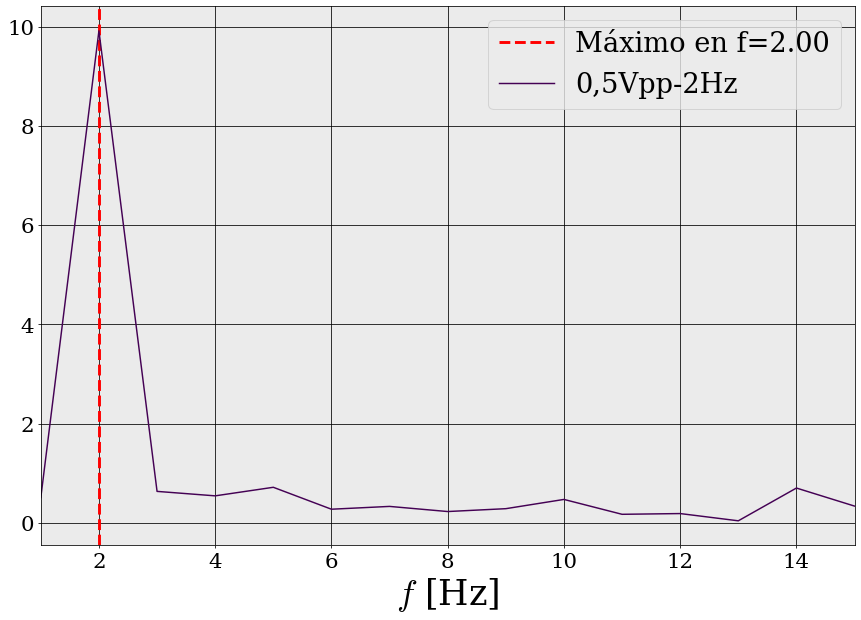

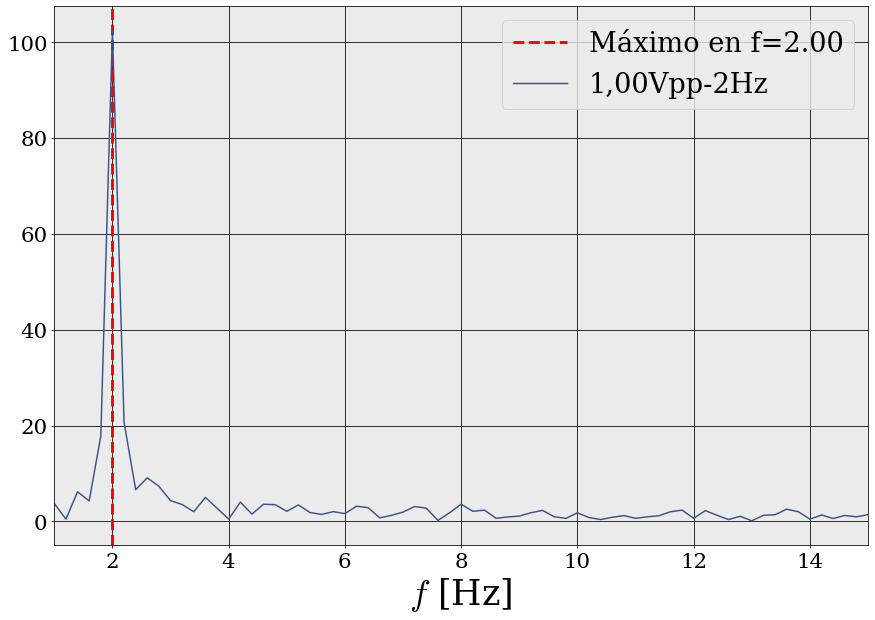

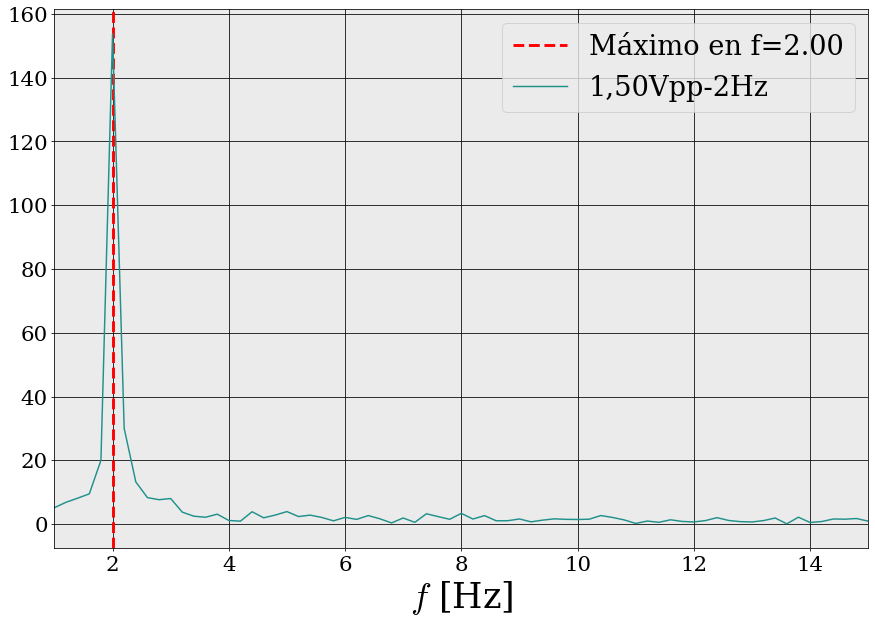

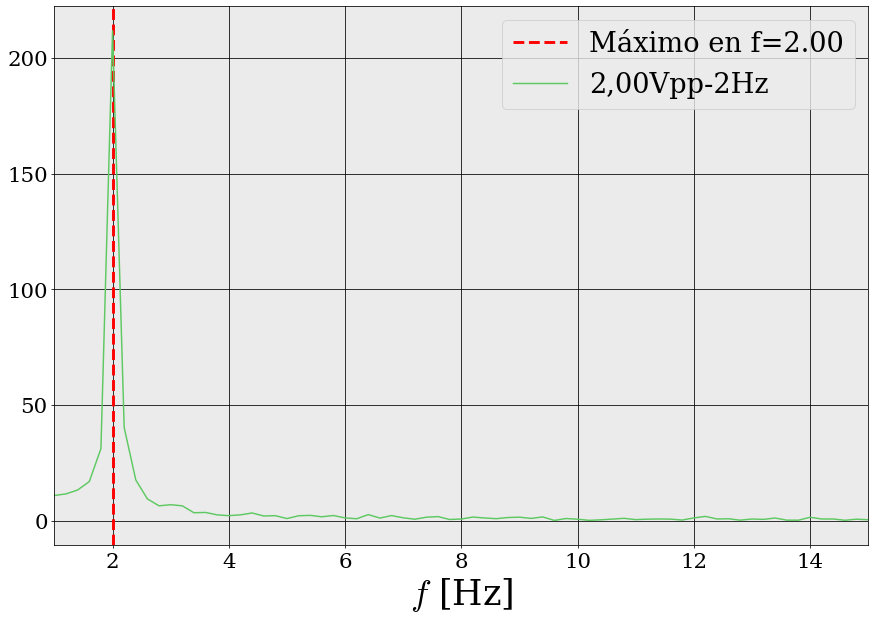

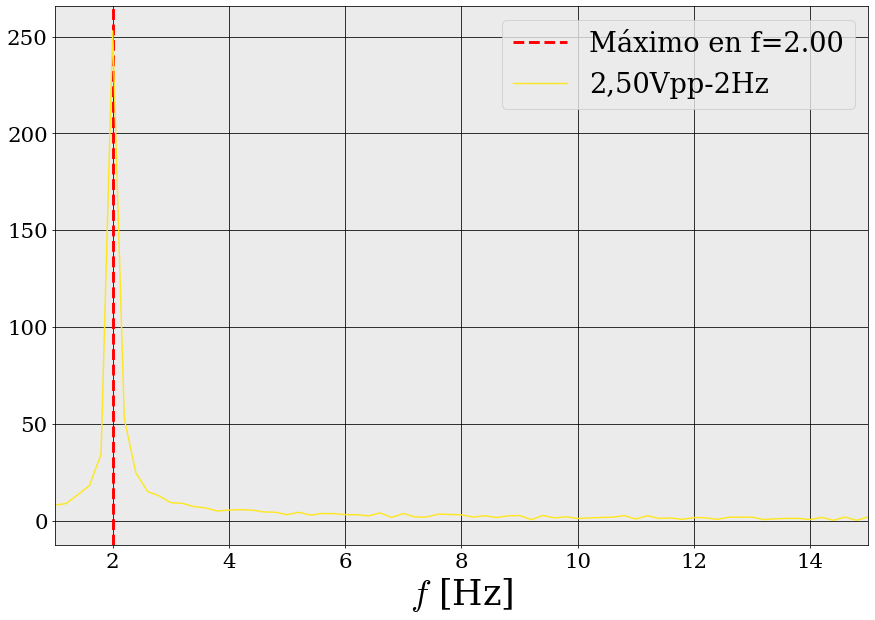

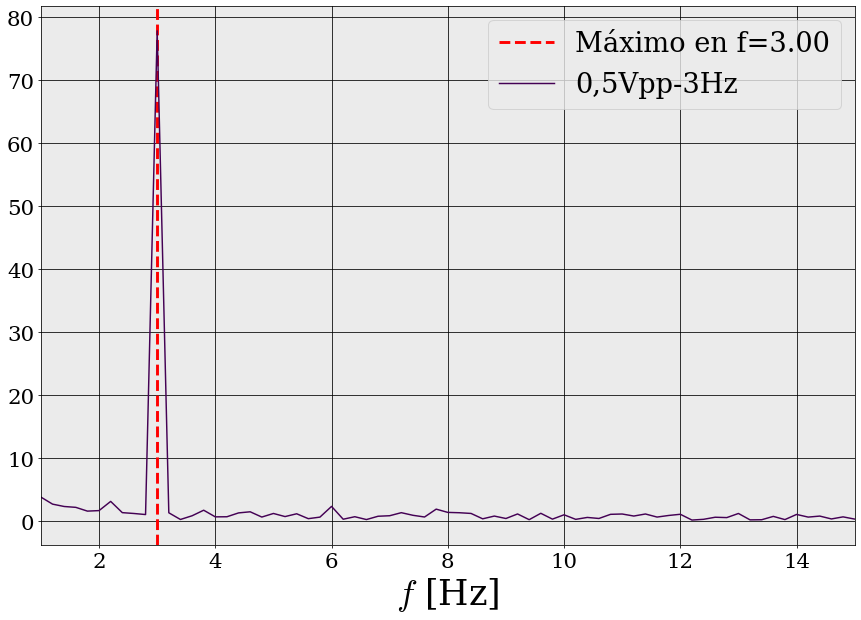

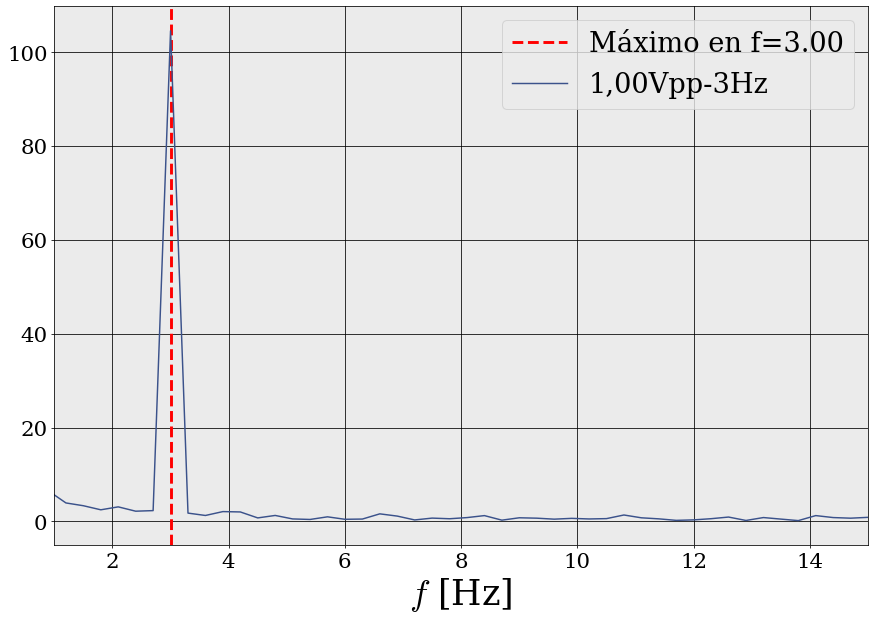

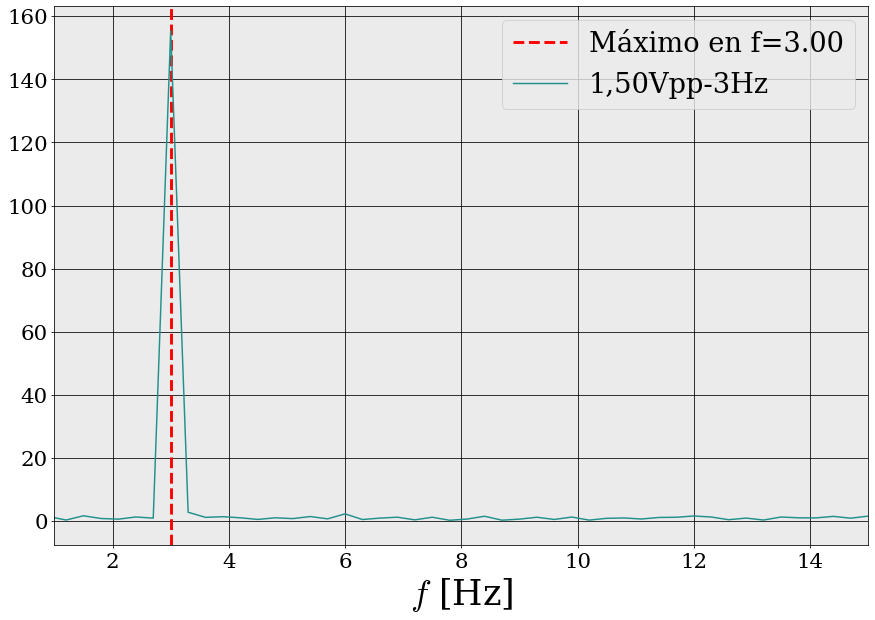

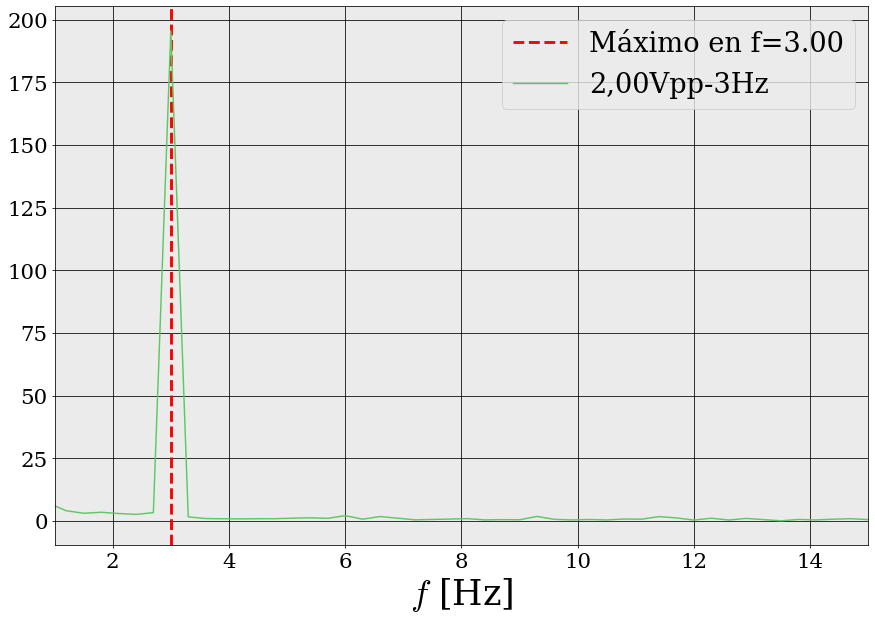

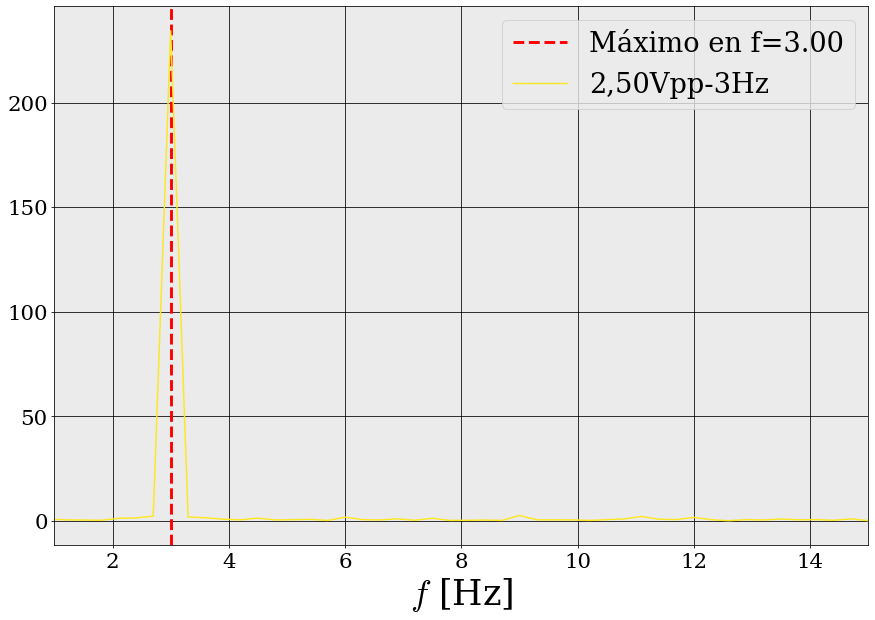

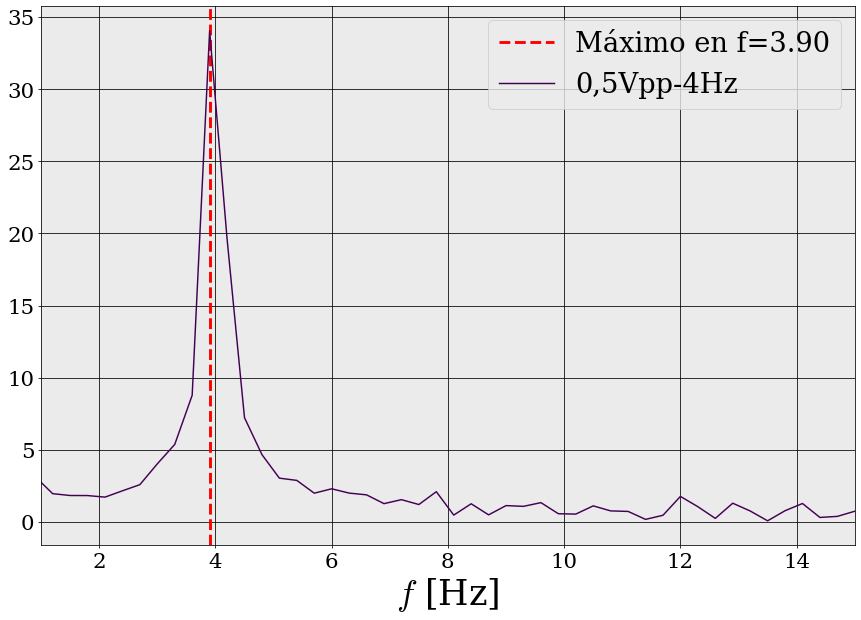

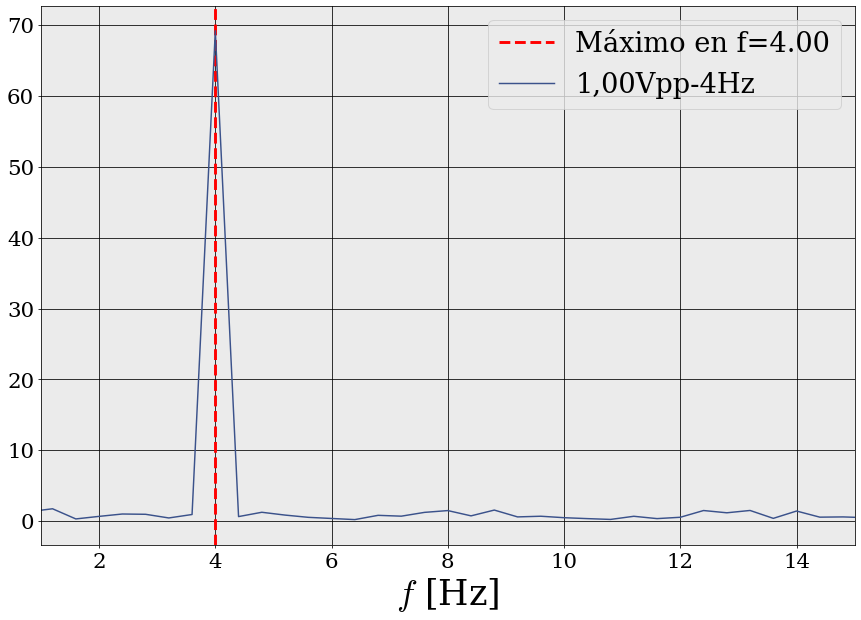

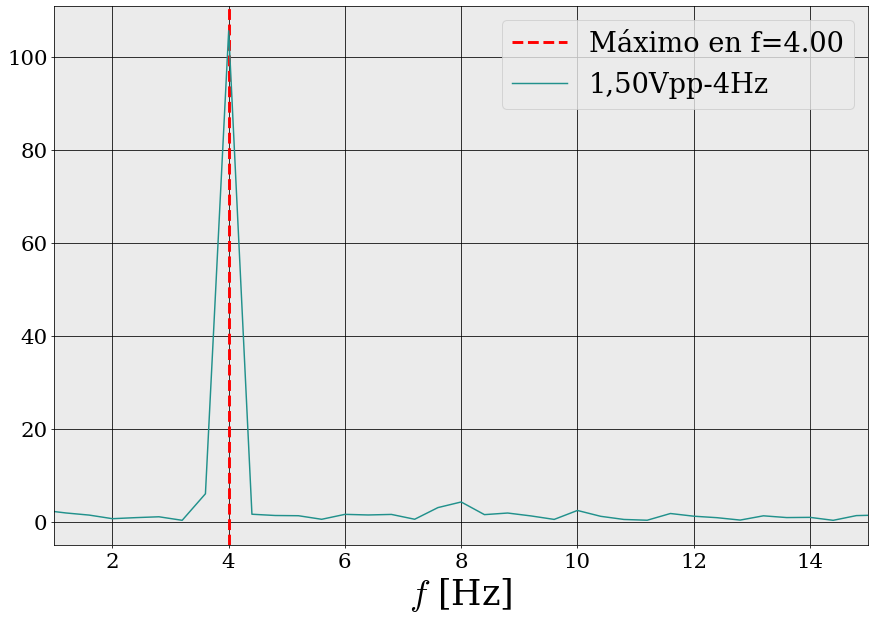

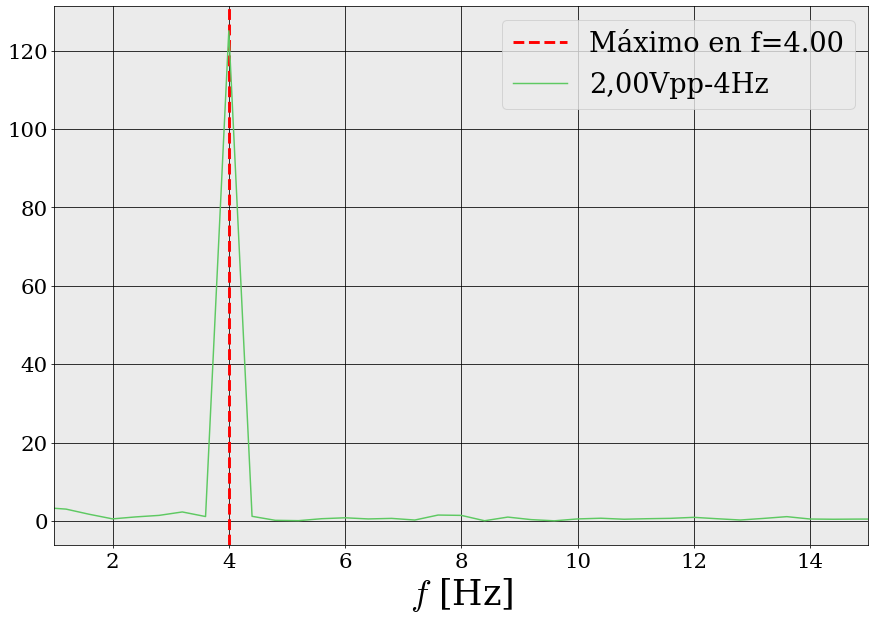

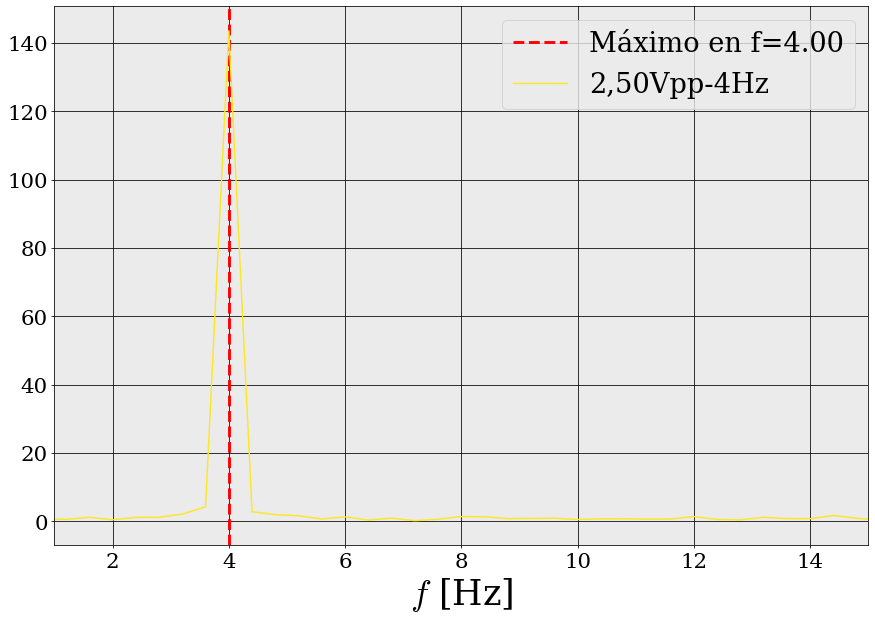

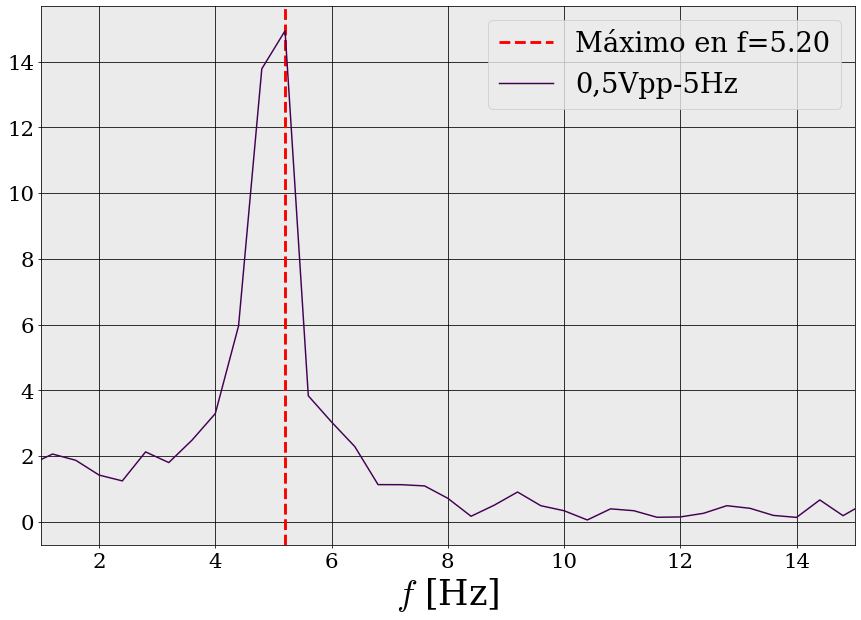

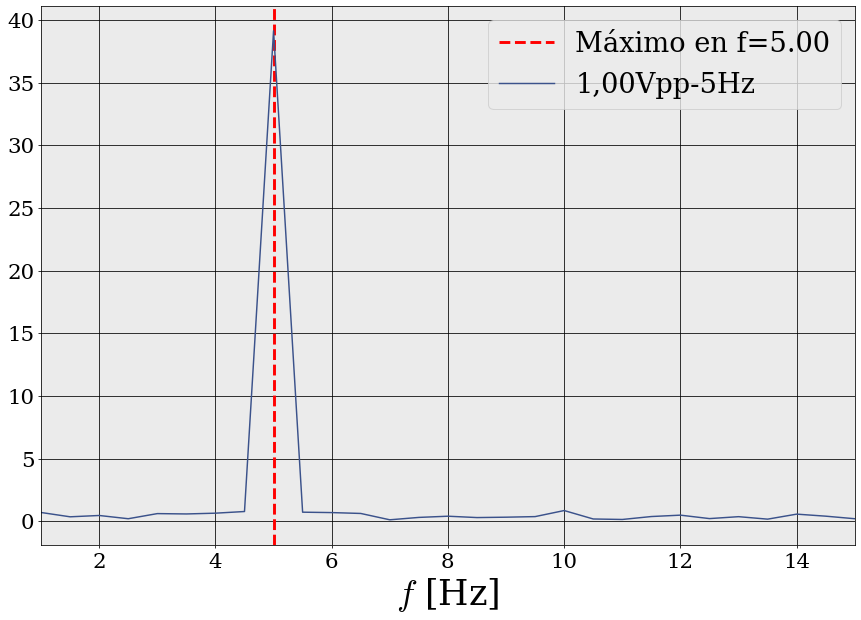

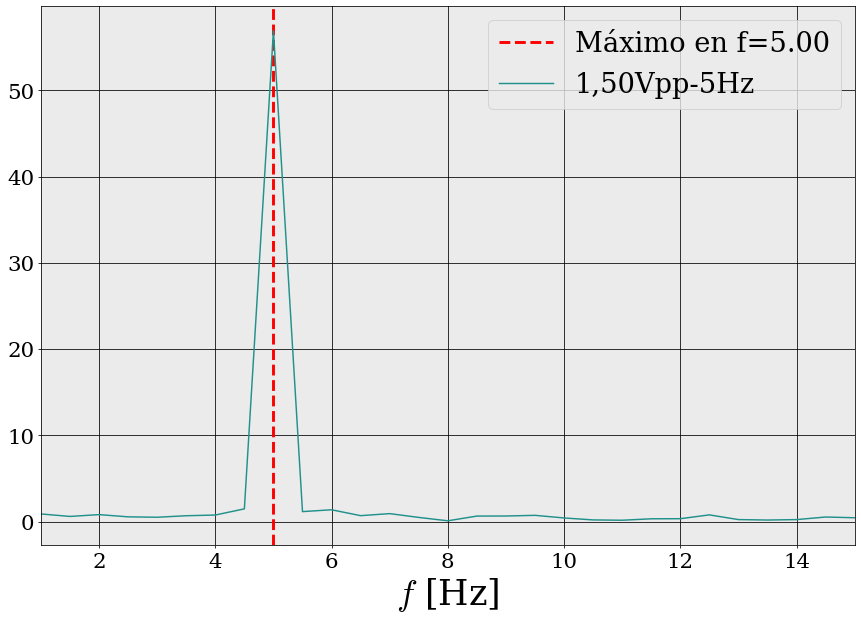

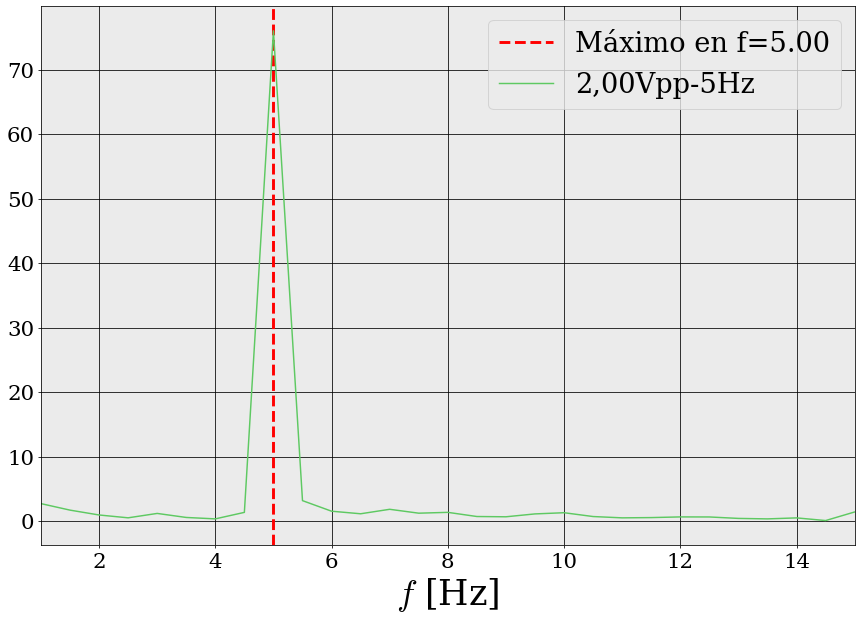

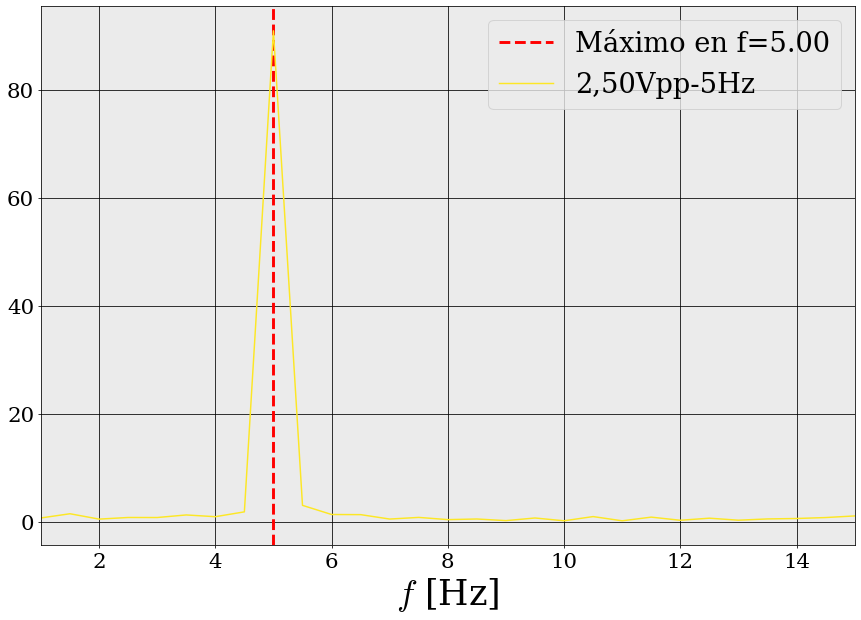

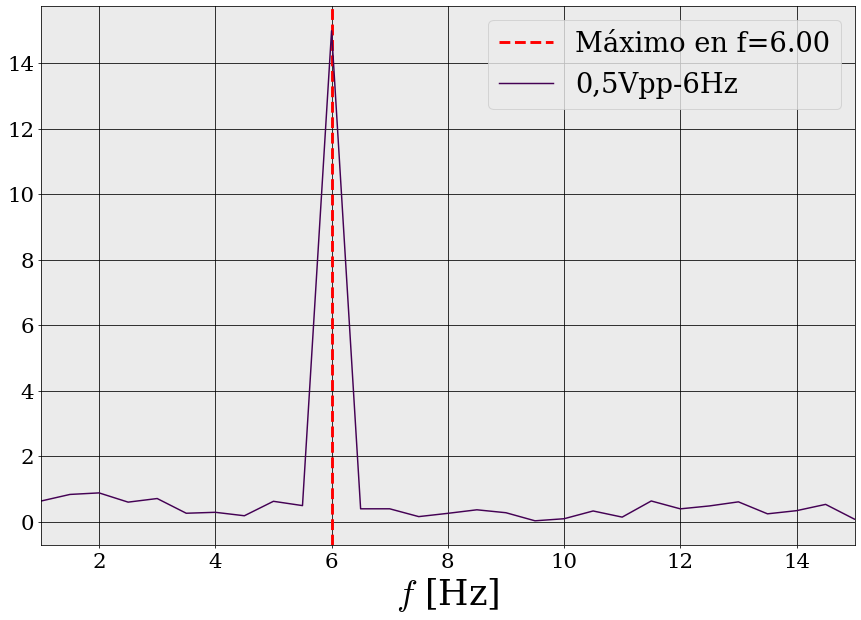

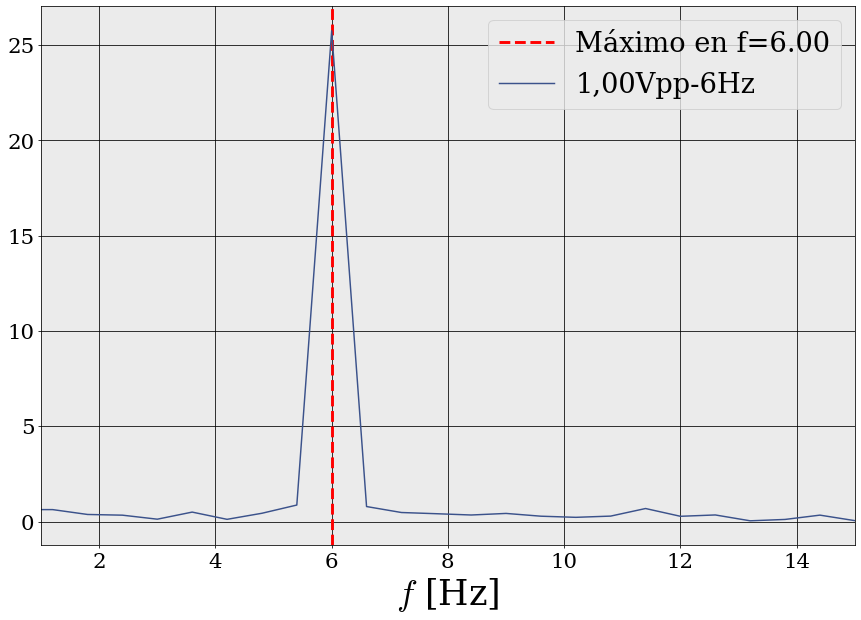

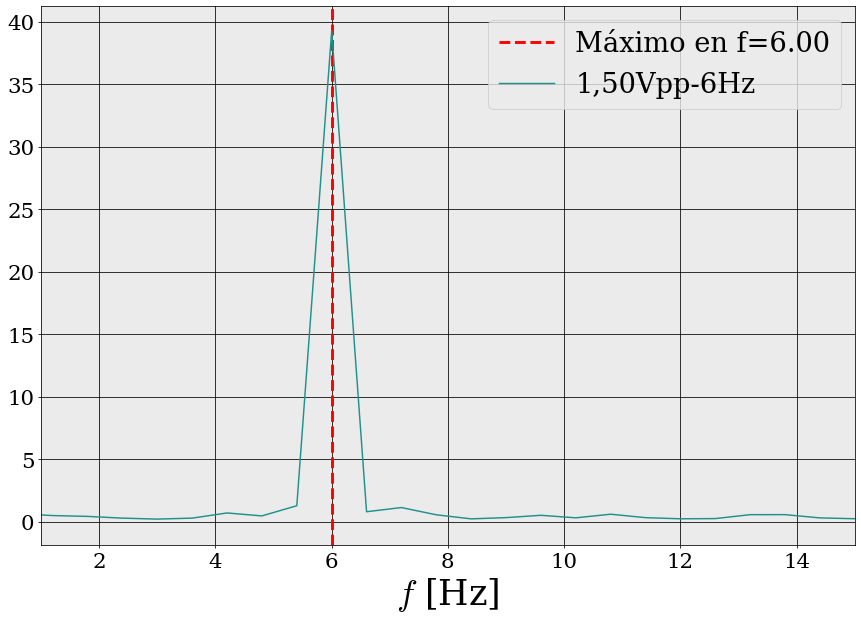

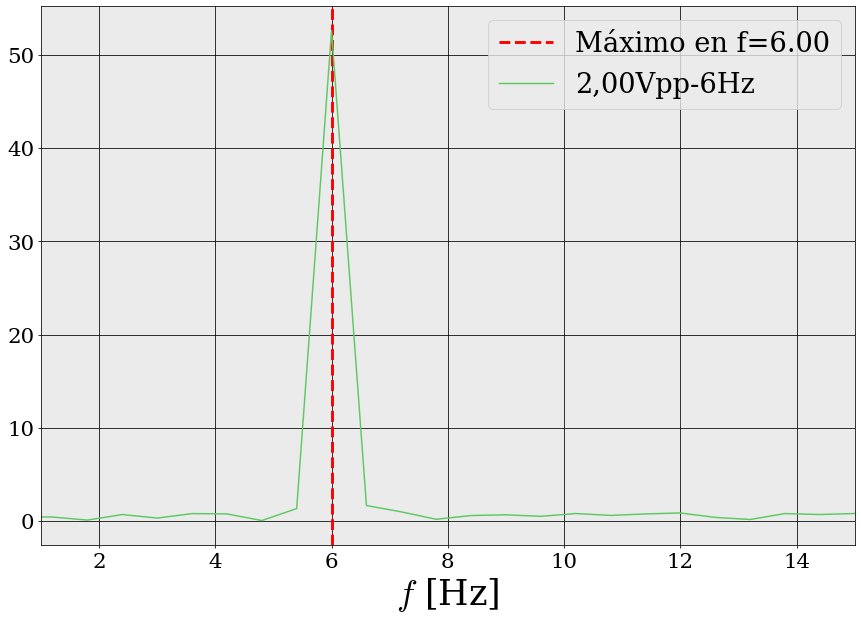

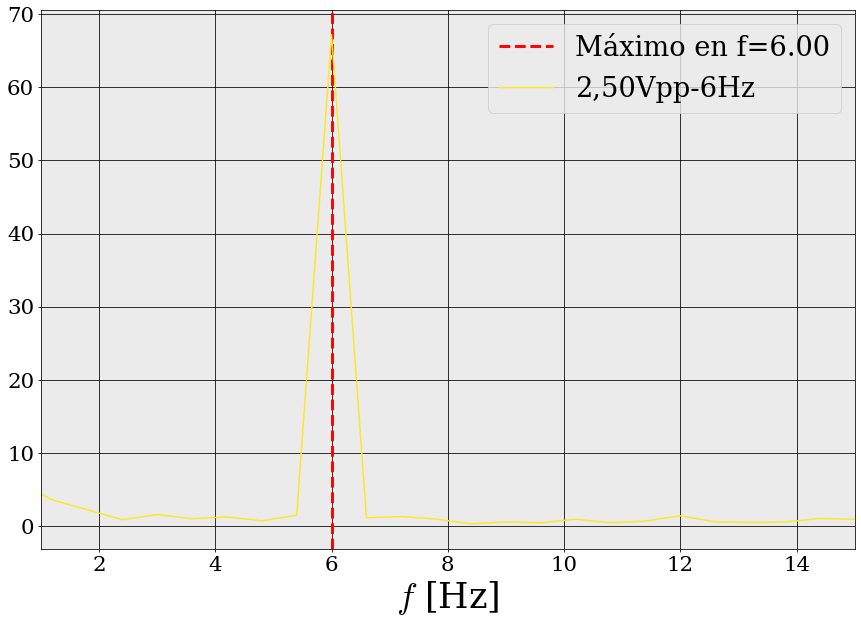

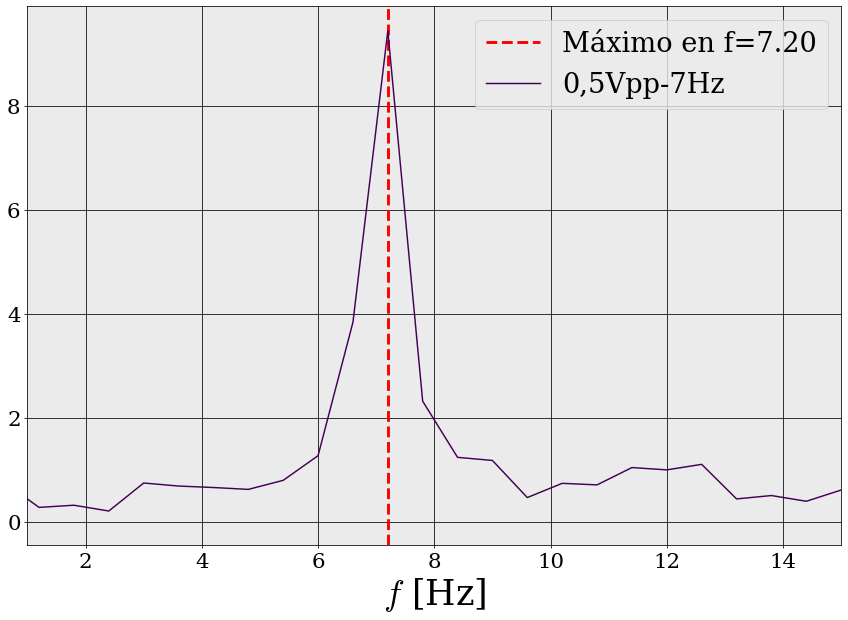

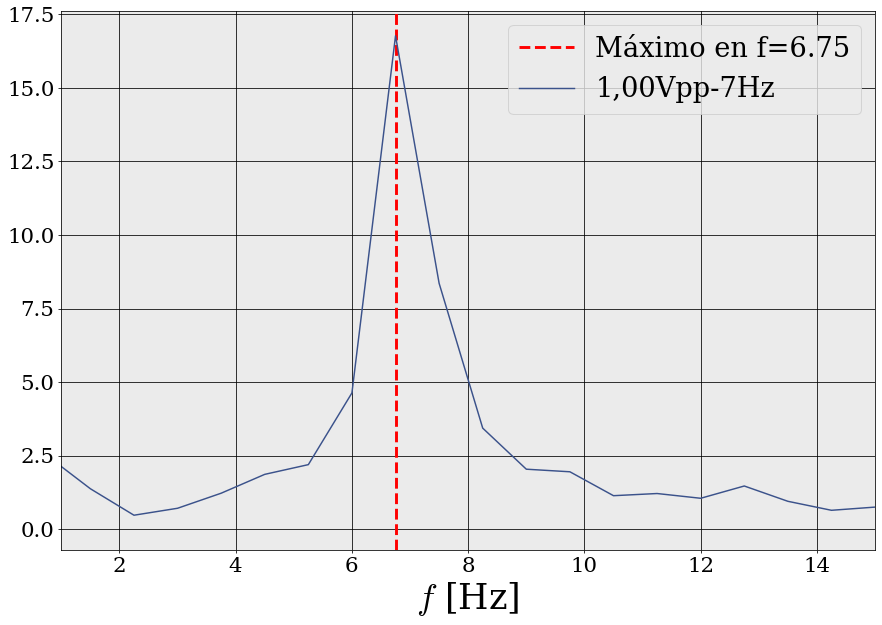

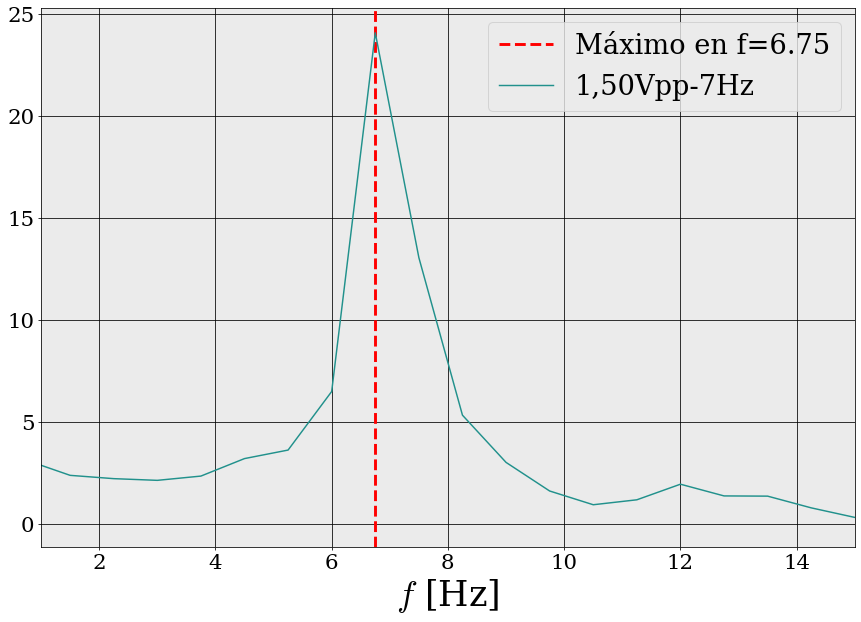

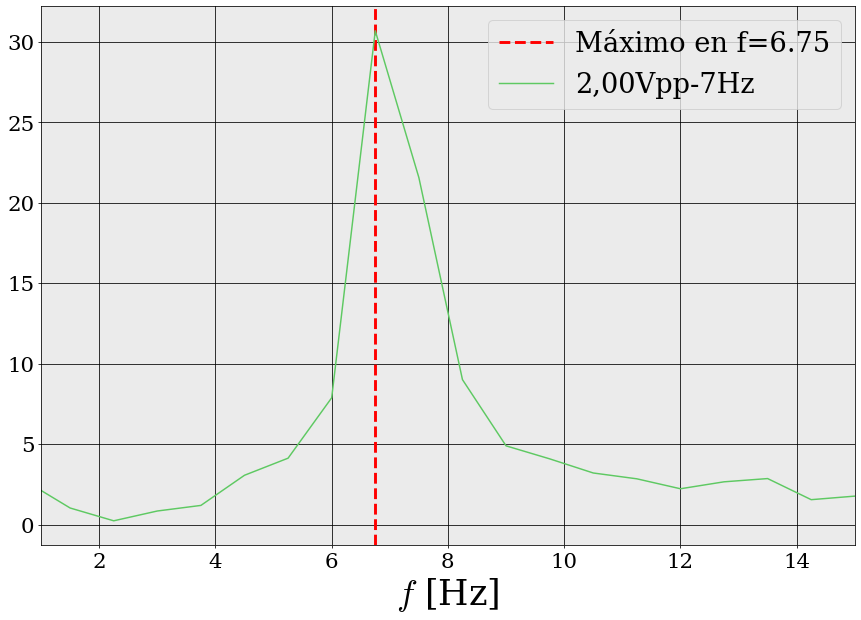

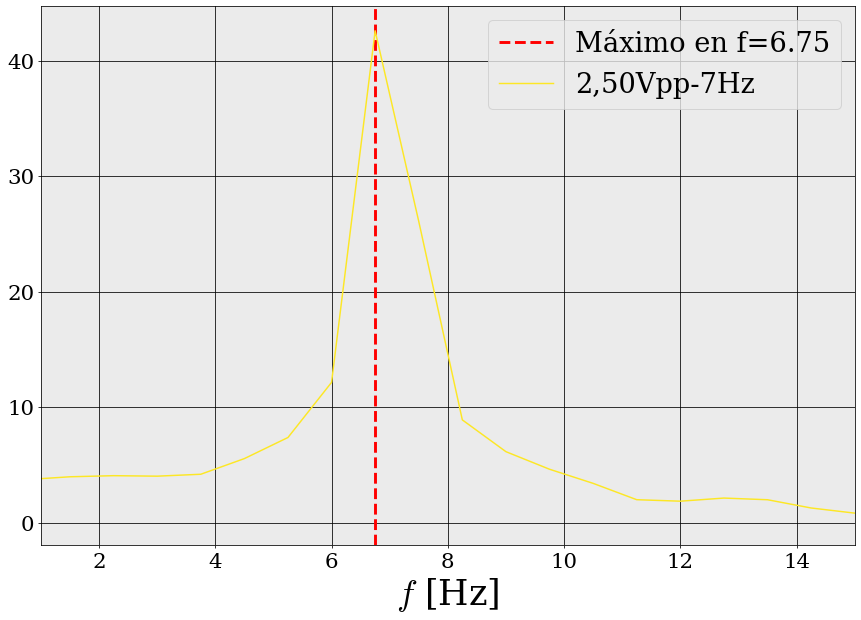

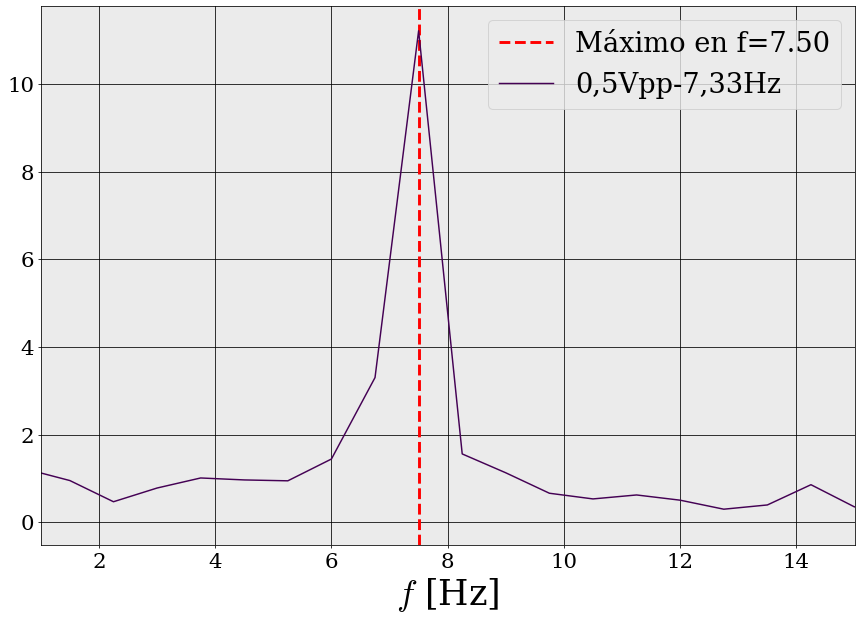

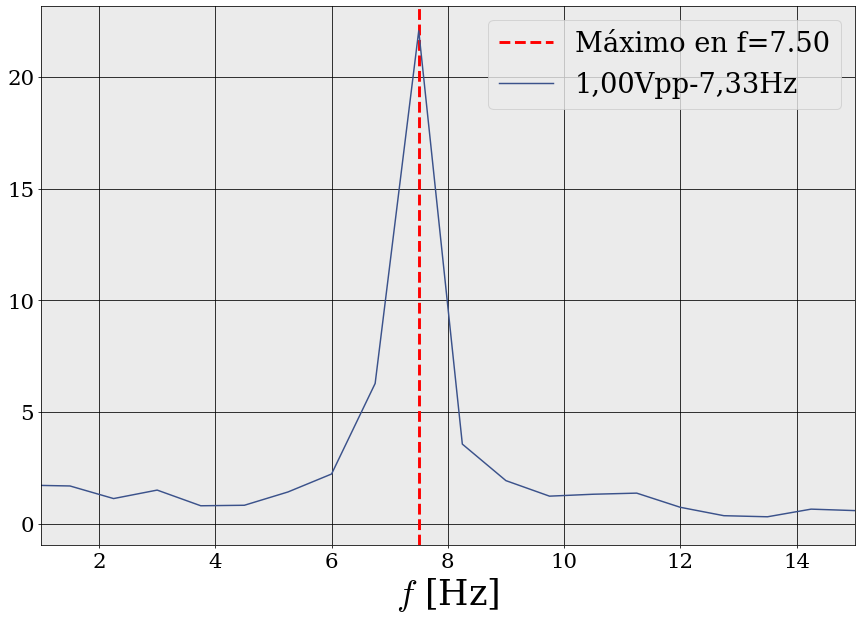

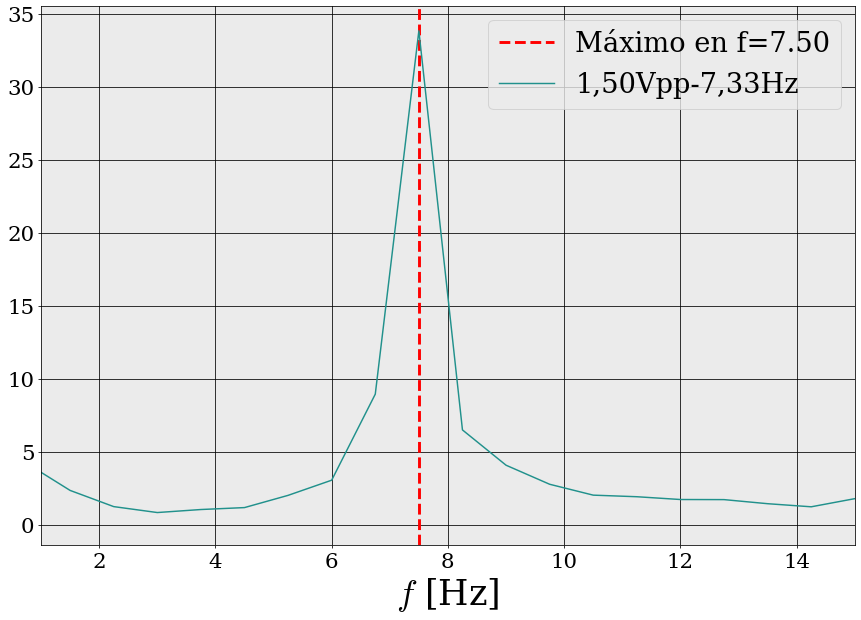

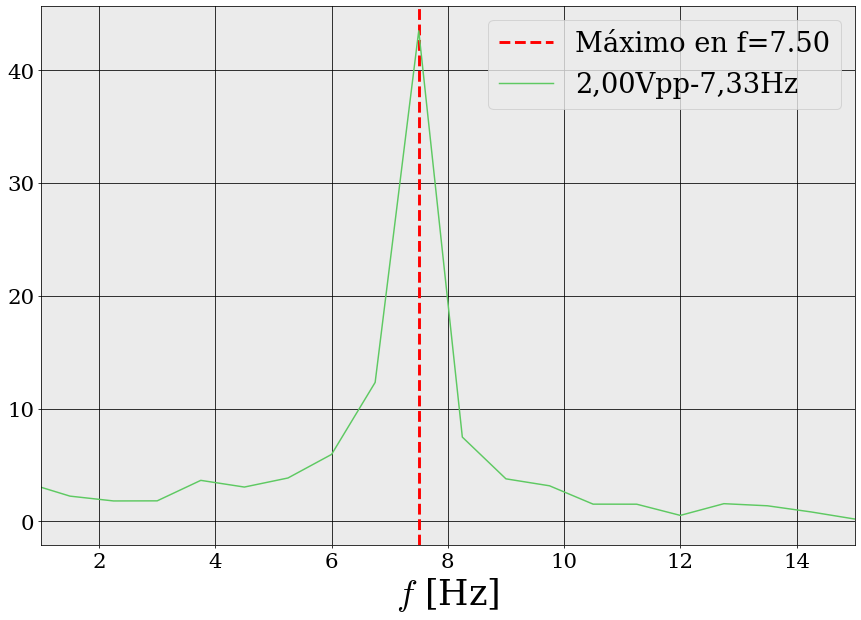

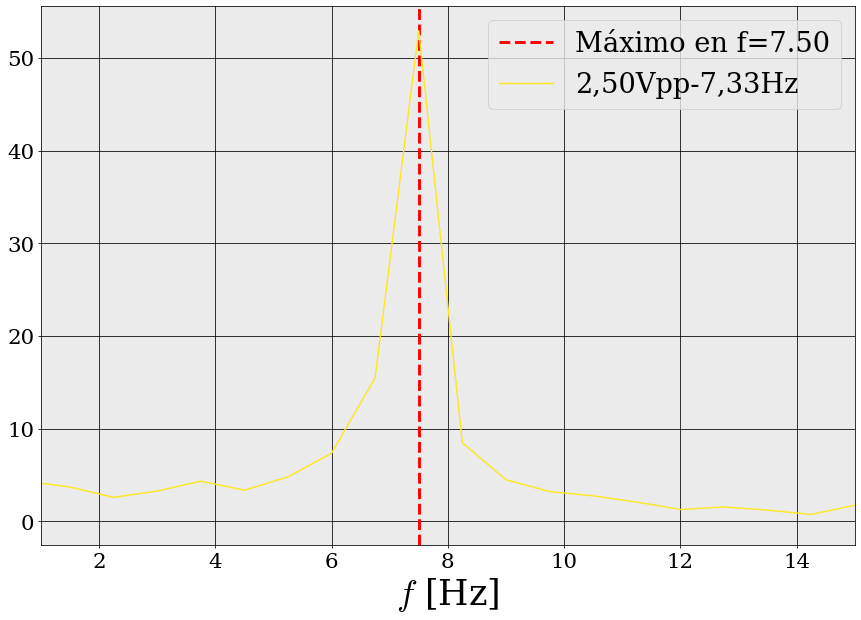

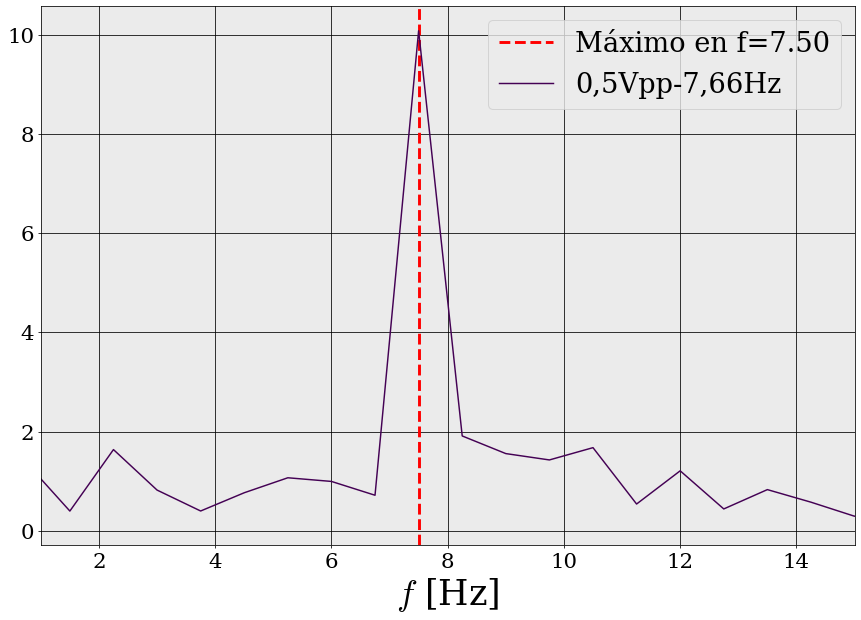

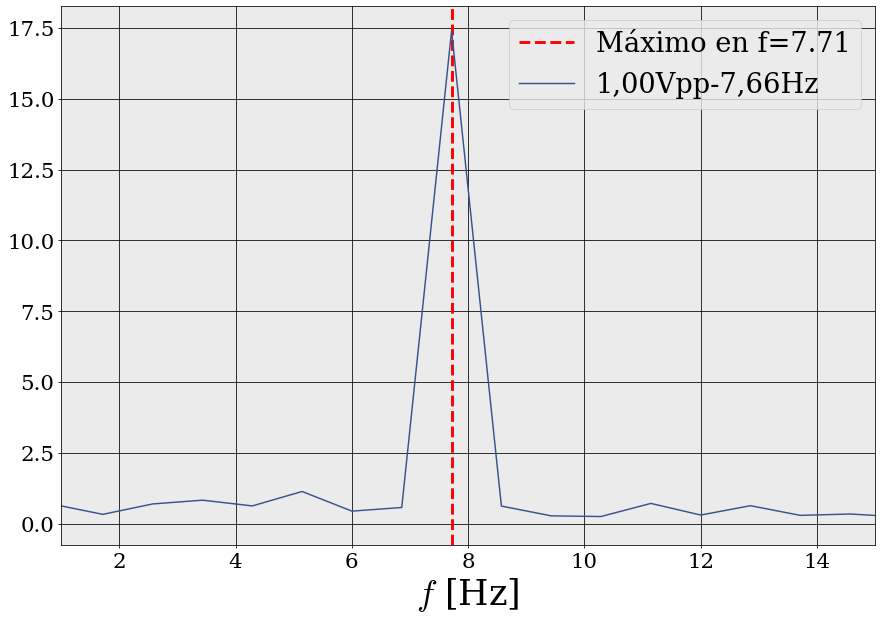

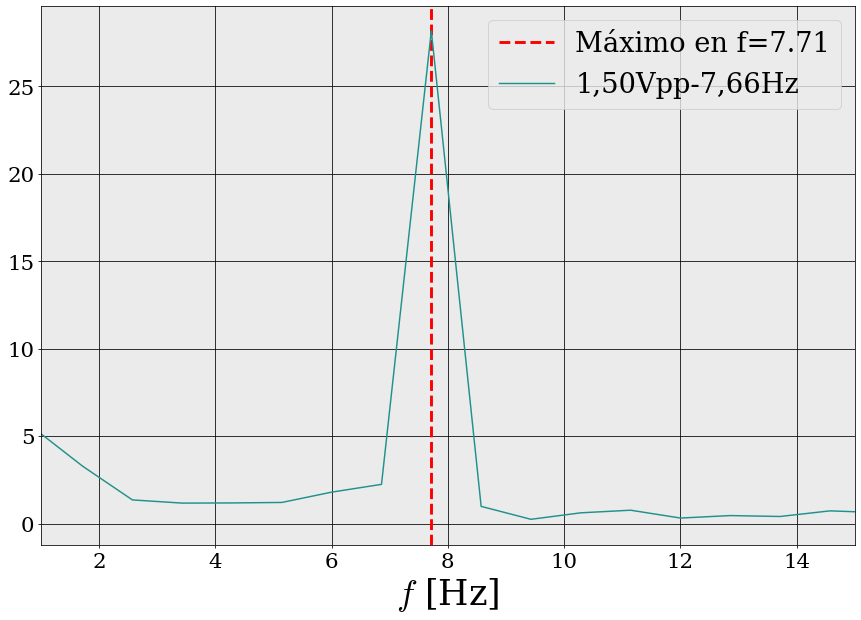

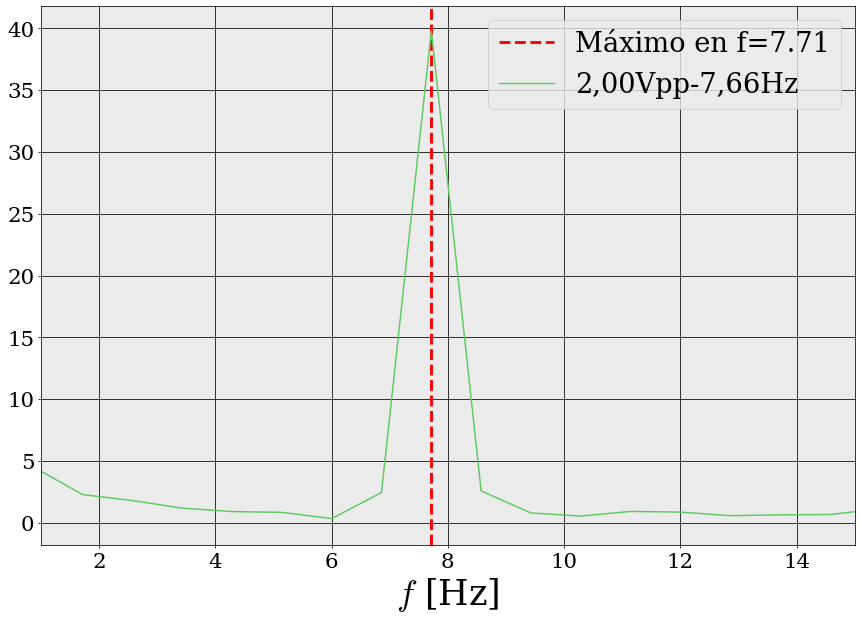

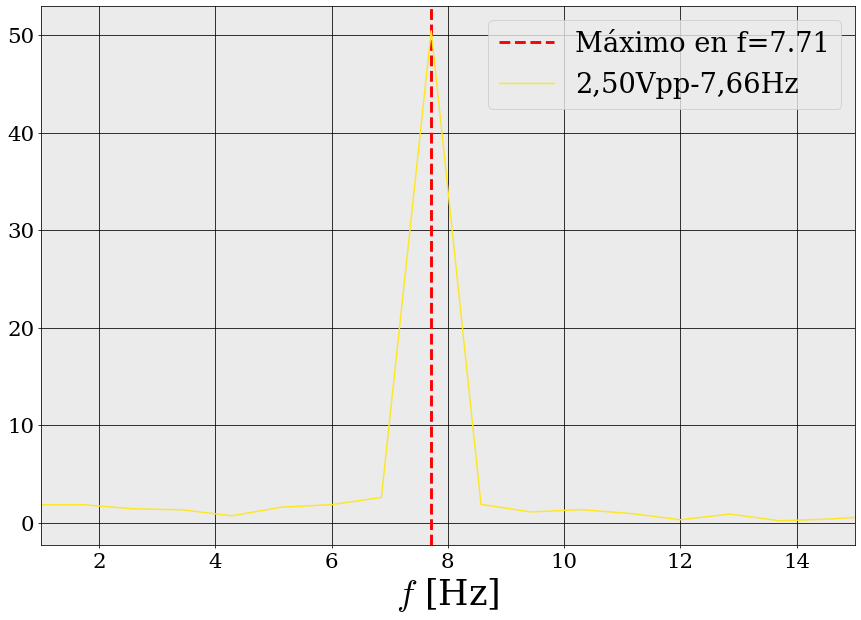

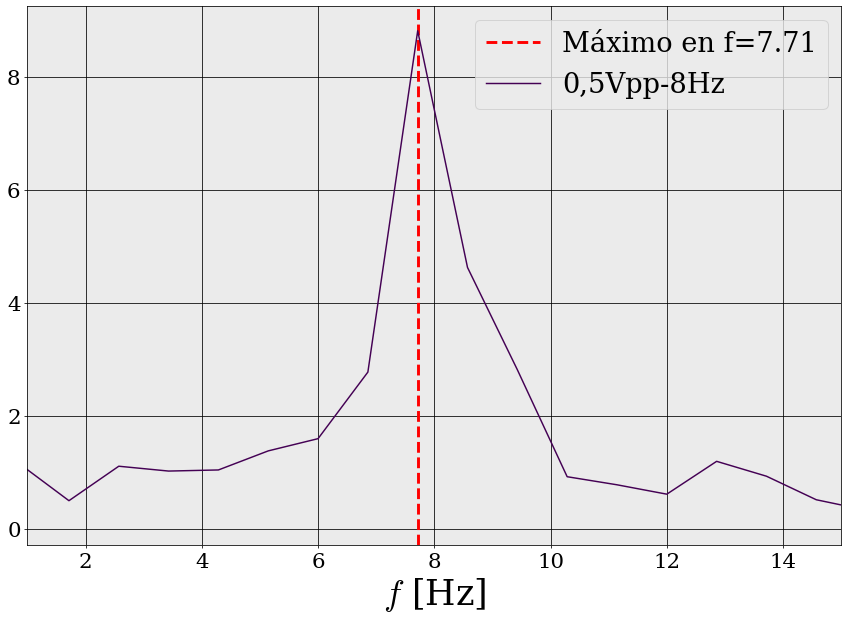

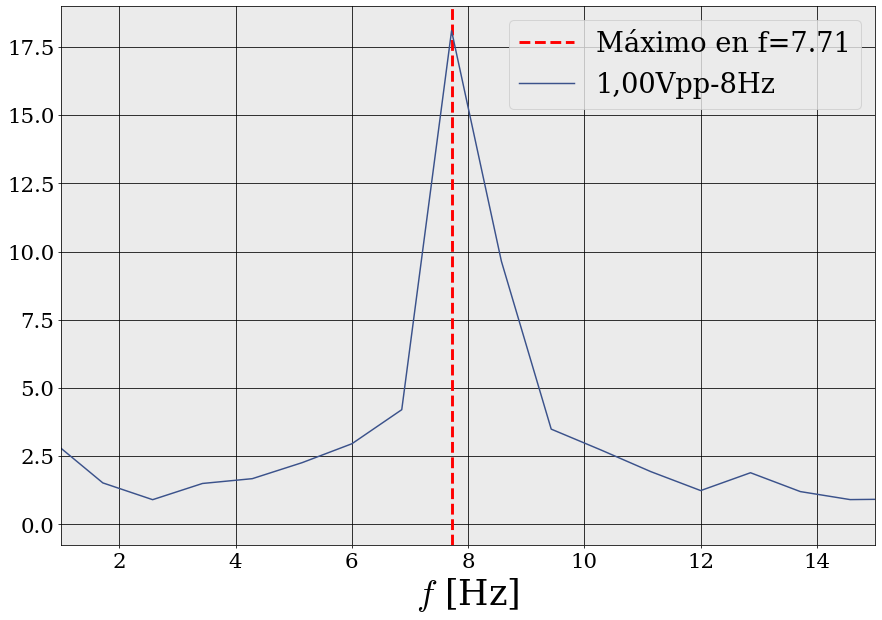

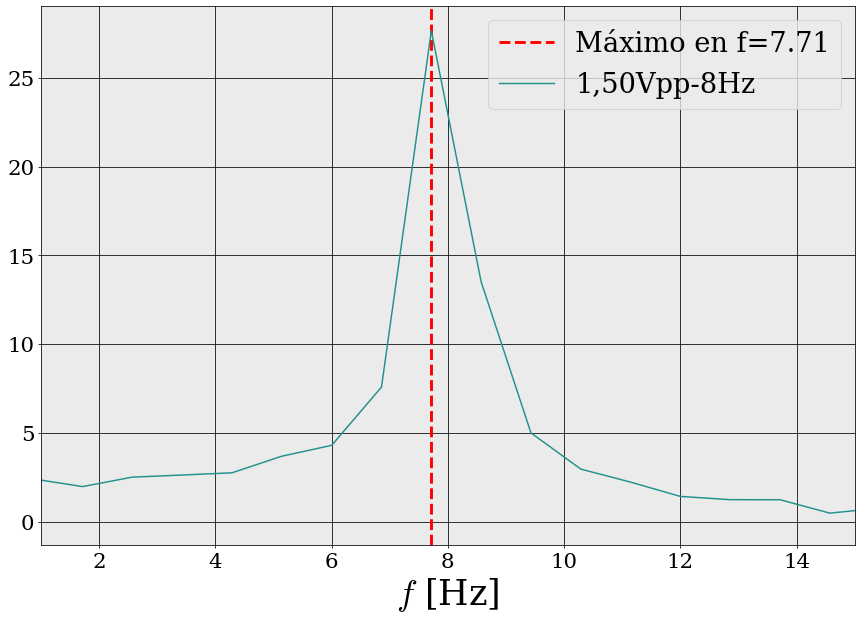

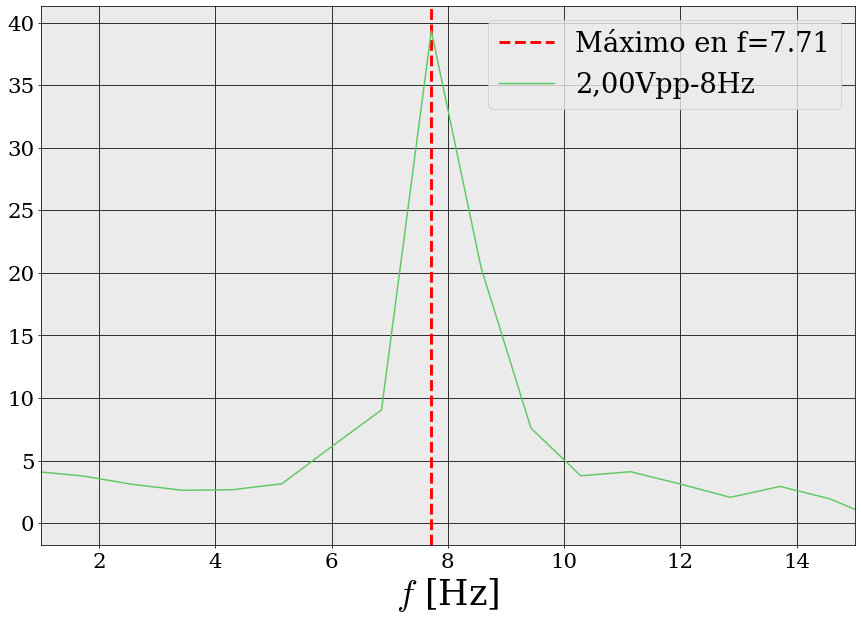

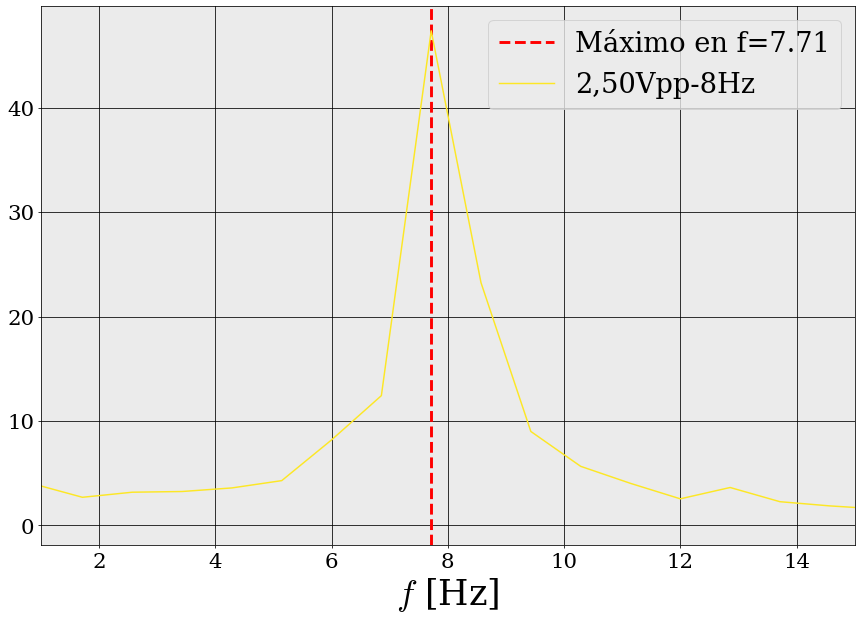

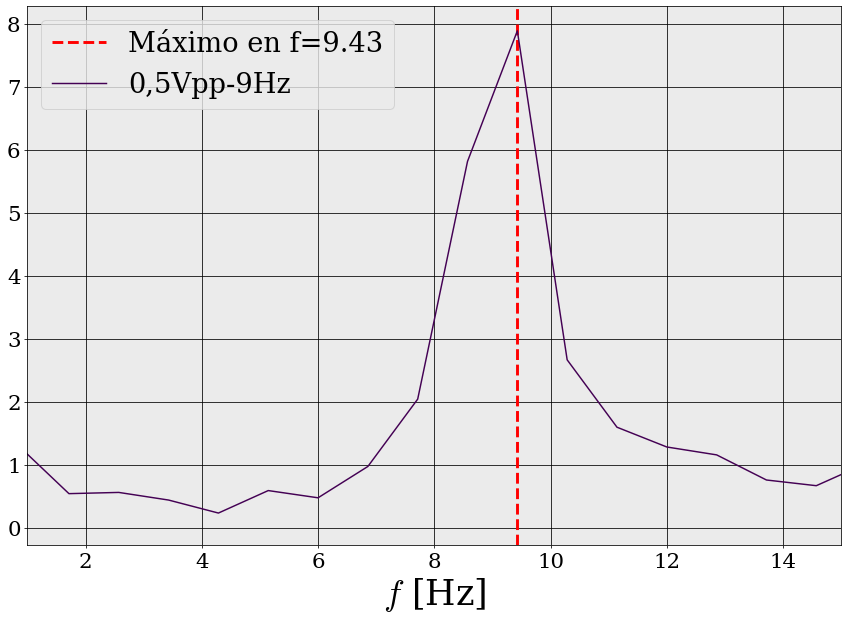

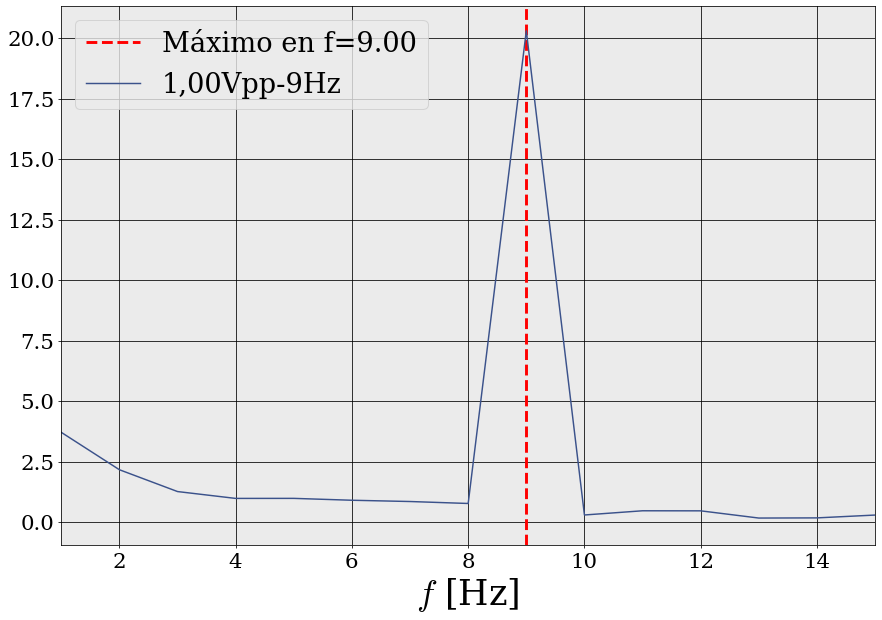

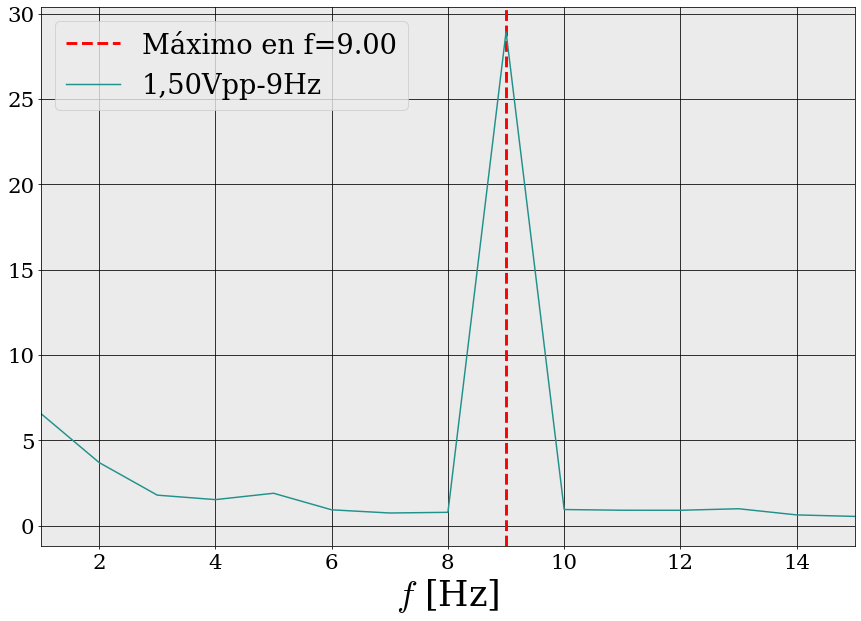

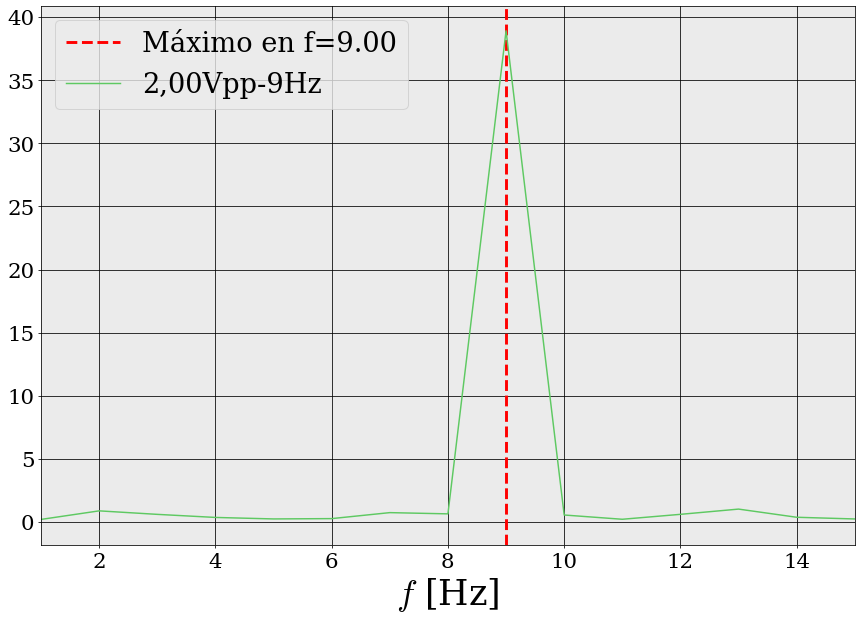

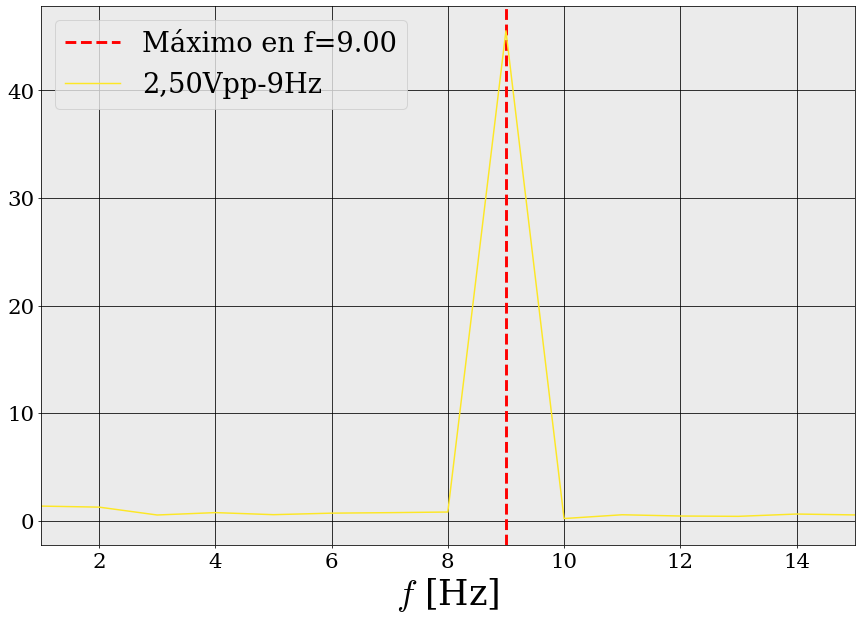

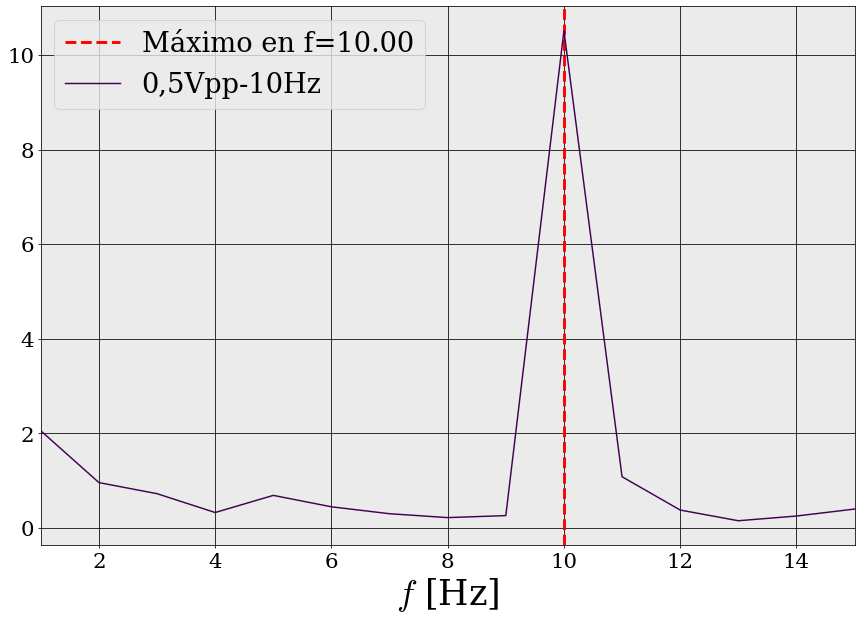

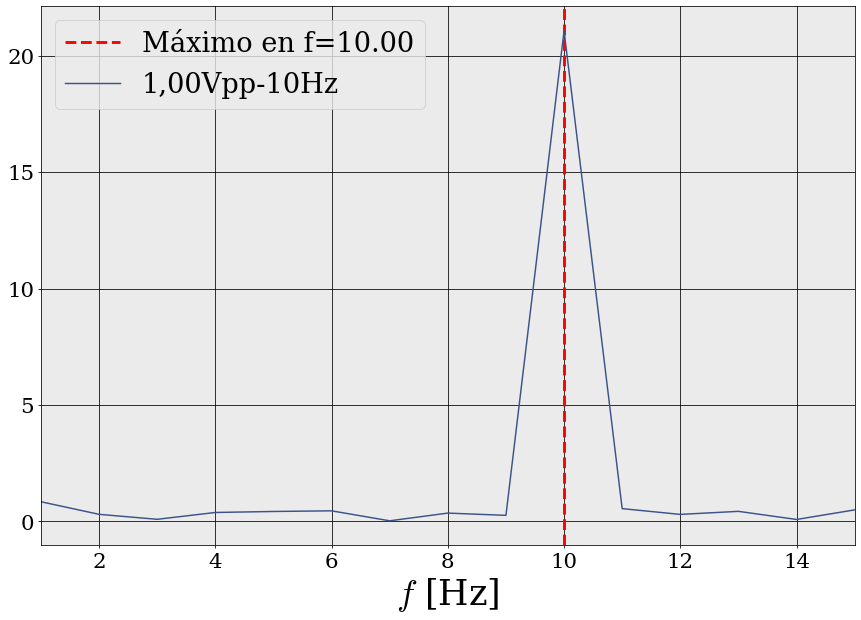

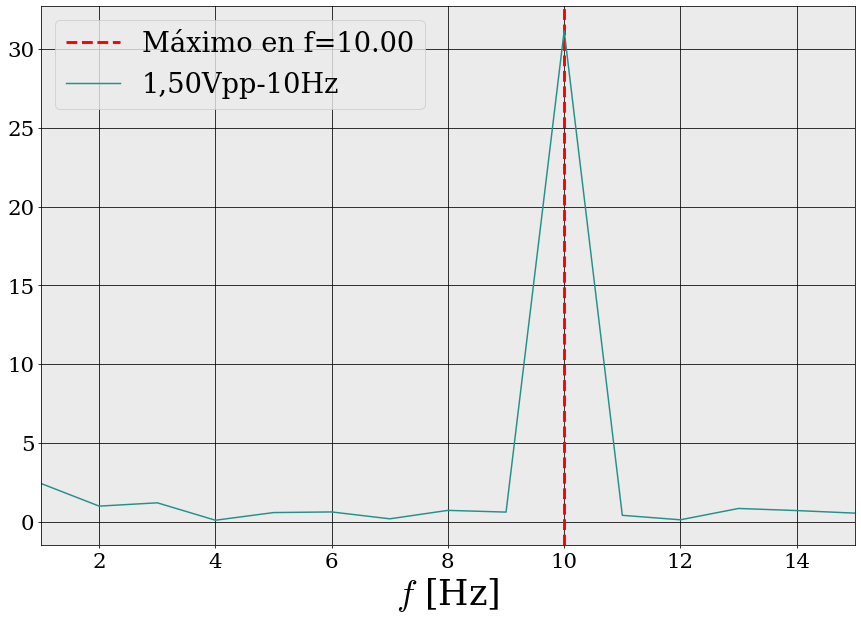

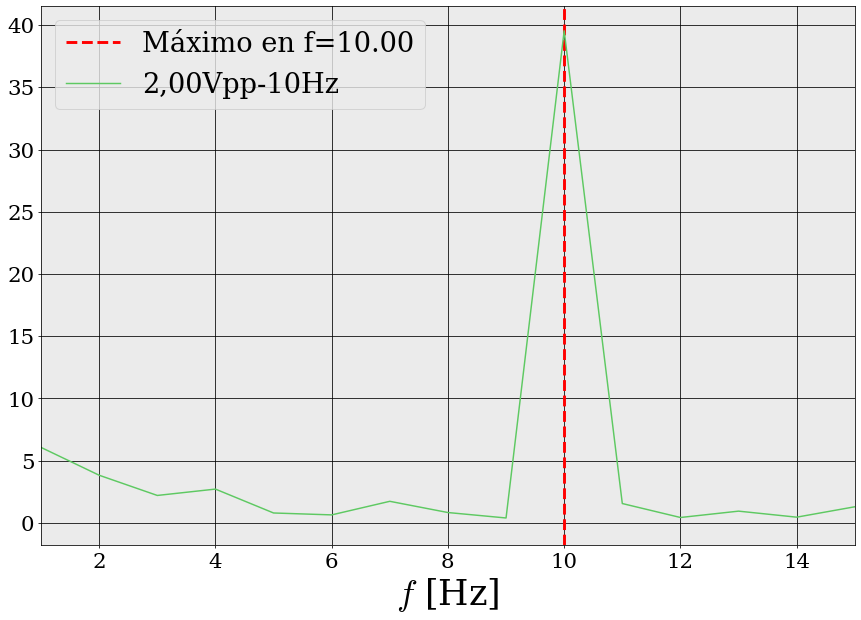

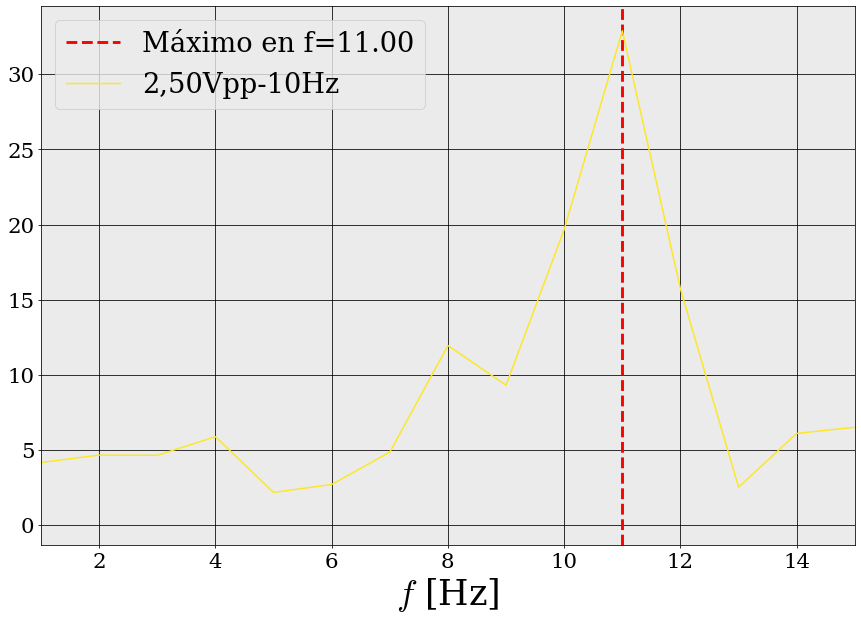

In [9]:
index_start = 0


for currHz in FREQ_ARRAY:
    filtered_namelist = [name for name in npz_names if re.match(r'\b'+currHz+r'\b',name.split('-')[1])] #We get the names of those files
    rotated_tails = np.array([np.load(f'ECO20-45mm/forma_cola_rotada/{name}', allow_pickle=True)['arr'] for name in filtered_namelist], dtype=object)
    
    for rotated_tail,filename in zip(rotated_tails,filtered_namelist):
        tail_extremes = np.array([(tail[1][0], tail[1][-1]) for tail in rotated_tail])
        head_position = tail_extremes[:,0]/PX_PER_MM
        tail_position = tail_extremes[:,1]/PX_PER_MM
        
        N_PERIOD = 10*int((fval**-1)*FRAME_PER_SECOND)
        
        fig, ax = plt.subplots()

        tf_head = np.abs(np.fft.rfft(head_position[:N_PERIOD]))[1:]
        
        
        freqs = np.fft.rfftfreq(len(head_position[:N_PERIOD]))[1:]
        
        fundamental = np.abs(FRAME_PER_SECOND*freqs[np.argmax(tf_head)]) #Descartamos la frecuencia 0
        
        df_freq.loc[vval,fval] = fundamental
        
        #We retrieve the metadata of our measurements from the filename
        s = filename.split('.')[0].split('-')
        v,f = s[0],s[1]
        vval = (float(v.split('V')[0].replace(',','.')) if 'mV' not in v else float(v.split('mV')[0].replace(',','.'))*1e-3)
        fval = float(f.split('Hz')[0].replace(',','.'))

        #Setting colors for our datapoints
        freq_color = cmap_f(norm_f(fval))
        volt_color = cmap_v(norm_v(vval))
        
        ax.axvline(fundamental, color='r', ls='--', lw=3, label=f'Máximo en f={fundamental:.2f}')
        ax.plot(np.abs(freqs*FRAME_PER_SECOND),tf_head, color= volt_color, ms=20, label=f'{v}-{f}')
        ax.legend()
        #Axes configuration
        ax.set_xlabel('$f$ [Hz]')
        ax.set_xlim([1,15])

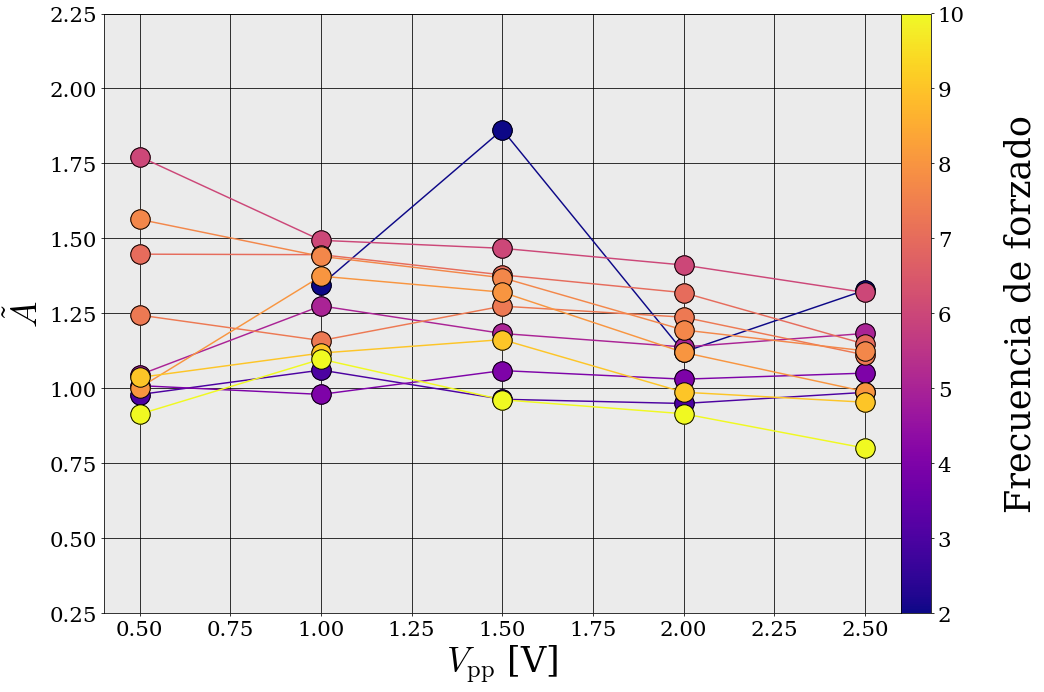

In [202]:
fig,ax = plt.subplots()
for tail_items,head_items in zip(df_tail_amplitude.items(),df_head_amplitude.items()):
    freq_color = cmap_f(norm_f(tail_items[0]))
    series_tail = tail_items[1]
    series_head = head_items[1]
    tail = np.array([amp[0] for amp in series_tail])
    err_tail = np.array([amp[1] for amp in series_tail])
    head = np.array([amp[0] for amp in series_head])
    err_head = np.array([amp[1] for amp in series_head])

    ax.plot(VOLT_ARRAY_VALUES, tail/head , '-o', ms=20, color=freq_color)
    ax.errorbar(VOLT_ARRAY_VALUES, tail/head , markerfacecolor = freq_color, fmt='o',
            yerr = 0, xerr = None, color = 'k', ecolor = freq_color, #TODO: Propagar error de adimenzionalicación
            ms=20, elinewidth=2, lw=3, capsize=10)
    
ax.set_xlabel('$V_{\\text{pp}}$ [V]')
ax.set_ylabel('$\\tilde{A}$')
ax.set_xlim([0.4,2.6])
ax.set_ylim([0.25,2.25]) 
cbar_term = fig.colorbar(colorscale_f, ax=ax, location='right', orientation='vertical', pad=0, fraction=0.05)
cbar_term.ax.set_ylim(2,10)
cbar_term.ax.ticklabel_format(axis='x',style='sci',scilimits=(0,2))
cbar_term.ax.set_yticks([f for f in FREQ_ARRAY_VALUES if f!=7.33 and f!=7.66])
cbar_term.ax.set_ylabel('Frecuencia de forzado',labelpad=40)
fig.tight_layout()

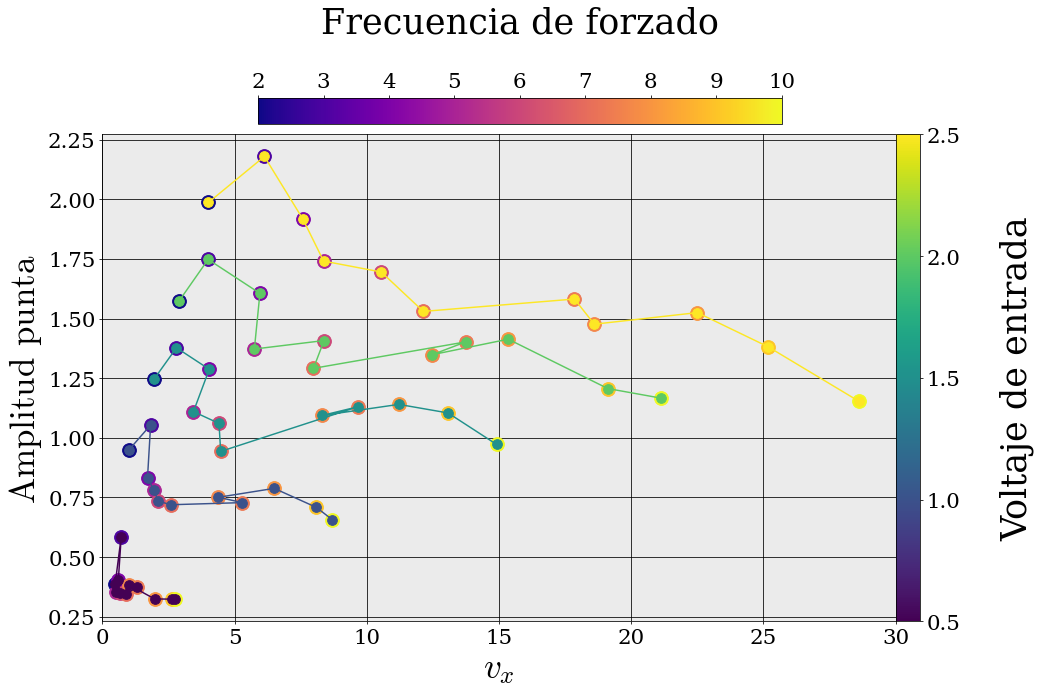

In [14]:
fig,ax = plt.subplots()

for i,vval in enumerate(VOLT_ARRAY_VALUES):
    volt_color = cmap_v(norm_v(vval))
    tail = np.array([amp[0] for amp in df_tail_amplitude.iloc[i]])
    err_tail = np.array([amp[1] for amp in df_tail_amplitude.iloc[i]])
    head = np.array([amp[0] for amp in df_head_amplitude.iloc[i]])
    err_head = np.array([amp[1] for amp in df_head_amplitude.iloc[i]])
    # freq_head = np.array([fhead for fhead in df_freq.iloc[i]]) #No funciona
    slopes = np.array([vx[0] for vx in df_slope.iloc[i]])
    slope_errors = np.array([vx[1] for vx in df_slope.iloc[i]])

    ax.plot(np.abs(slopes), tail,'o-', ms=10, color = volt_color)
    for i,fval in enumerate(FREQ_ARRAY_VALUES):
        freq_color = cmap_f(norm_f(fval))
        ax.scatter(np.abs(slopes[i]),(tail)[i], s=200, color = freq_color)
    # ax.errorbar(np.abs(slopes), amplitudes, markerfacecolor = volt_color, fmt='o',
    #         yerr = amplitude_errors, xerr = slope_errors, color = 'k', ecolor = 'k',
    #         ms=10, elinewidth=2, lw=1, capsize=10)
    
ax.set_xlabel('$v_x$')
ax.set_ylabel('$\\text{Amplitud punta}$')   
ax.set_xlim([0,30])
# ax.set_ylim([0.25,2.25])

cbar_term_f = fig.colorbar(colorscale_f, ax=ax, location='top', orientation='horizontal', pad=0.02, fraction=0.05)
cbar_term_f.ax.set_xlim(2,10)
cbar_term_f.ax.ticklabel_format(axis='x',style='sci',scilimits=(0,2))
cbar_term_f.ax.set_xticks(np.arange(2,11))
cbar_term_f.ax.set_xlabel('Frecuencia de forzado',labelpad=40)


cbar_term_v = fig.colorbar(colorscale_v, ax=ax, location='right', orientation='vertical', pad=0, fraction=0.05)
cbar_term_v.ax.set_ylim(0.5,2.5)
cbar_term_v.ax.ticklabel_format(axis='x',style='sci',scilimits=(0,2))
cbar_term_v.ax.set_yticks(VOLT_ARRAY_VALUES)
cbar_term_v.ax.set_ylabel('Voltaje de entrada',labelpad=40)
fig.tight_layout()
